In [1]:
import cv2
import mediapipe as mp
import numpy as np
from numpy import asarray
from numpy import save

In [2]:
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5)

In [3]:
# Getting the input video for pose estimation

cap = cv2.VideoCapture('dgi-1m-t1.mp4')

# Number to convert the real world coordinate from meters to milimeters
num = 1000

In [4]:
# Landmarks dictionary to define body segments landmarks according to BlazePose Topology

landmarks_coordinates = {}

thigh_segments = {"Left Thigh": [23, 25], "Right Thigh": [24, 26]}

upperarm_segments = {"Left Upper Arm": [11, 13], "Right Upper Arm": [12, 14]}

forearm_segments = {"Left Fore Arm": [13, 15], "Right Fore Arm": [14, 16]}

leg_segments = {"Left Leg": [25, 27], "Right Leg": [26, 28]}

foot_segments = {"Left foot": [27, 31], "Right foot": [28, 32]}

hands_segments = {"Left hand": [15, 19], "Right hand": [16, 20]}

shoulder_segment = {"Shoulder": [12, 11]}

hips_segment = {"Hips": [24, 23]}

trunk_segment = {"trunk": [34, 33]}

In [5]:
# Function to calculate CoM coordinates for segments defined in the dictionary

def calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j):
    x1 = (x_i + x_j) * 0.5
    y1 = (y_i + y_j) * 0.5
    z1 = (z_i + z_j) * 0.5

    return x1, y1, z1

def calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h):
    x2 = x_g + 0.433 * (x_h - x_g)
    y2 = y_g - 0.433 * (y_g - y_h)
    z2 = z_g - 0.433 * (z_g - z_h)

    return x2, y2, z2


def calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b):
    x3 = x_a + 0.433 * (x_b - x_a)
    y3 = y_a - 0.433 * (y_a - y_b)
    z3 = z_a - 0.433 * (z_a - z_b)

    return x3, y3, z3


def calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d):
    x4 = x_c + 0.436 * (x_d - x_c)
    y4 = y_c - 0.436 * (y_c - y_d)
    z4 = z_c - 0.436 * (z_c - z_d)

    return x4, y4, z4


def calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f):
    x5 = x_e + 0.430 * (x_f - x_e)
    y5 = y_e - 0.430 * (y_e - y_f)
    z5 = z_e - 0.430 * (z_e - z_f)

    return x5, y5, z5


def calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p):
    x6 = x_o + 0.506 * (x_p - x_o)
    y6 = y_o - 0.506 * (y_o - y_p)
    z6 = z_o - 0.506 * (z_o - z_p)

    return x6, y6, z6


def calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r):
    x7 = x_q - 0.66 * (x_q - x_r)
    y7 = y_q - 0.66 * (y_q - y_r)
    z7 = z_q - 0.66 * (z_q - z_r)    

    return x7, y7, z7


def calculate_average(x_l, x_r, y_l, y_r, z_l, z_r):
    x = (x_l + x_r) * 0.5
    y = (y_l + y_r) * 0.5
    z = (z_l + z_r) * 0.5
    
    return x, y, z

In [6]:
### Pose estimation for one individual in a video

# While the video is running, perform pose detection 
while True:
    success, image = cap.read()
    results = pose.process(image)
    
    # Defining a variable to calculate the whole body CoM in the end, by getting
    # all the segment´s CoM coordinates values
    com_body = 0
    
    # Check if any landmarks are found.
    if results.pose_world_landmarks:
        # draw the connections between joint landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 ) 
        # Enumerate each landmark according to BlazePose Topology 
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = image.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            #cv2.circle(image, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
            if idx == 29:
                #print(idx, lm.x, lm.y, lm.z)
                print("[%s, %s, %s],\n" % (str(lm.x), str(lm.y), str(lm.z)))
            landmarks_coordinates[idx] = {"x": lm.x, "y": lm.y, "z": lm.z}

       # Calculating trunk CoM coordinates by defining the average point in the shoulder and
        # hips segment
        x_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["x"]
        y_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["y"]
        z_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["z"]
        x_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["x"]
        y_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["y"]
        z_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["z"]
        x_average_shoulder, y_average_shoulder, z_average_shoulder = calculate_average(
            x_left_shoulder, x_right_shoulder, y_left_shoulder, y_right_shoulder, z_left_shoulder, z_right_shoulder
        )

        landmarks_coordinates[33] = {"x": x_average_shoulder, "y": y_average_shoulder, "z": z_average_shoulder}

        x_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["x"]
        y_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["y"]
        z_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["z"]
        x_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["x"]
        y_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        z_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        x_average_hips, y_average_hips, z_average_hips = calculate_average(
            x_left_hips, x_right_hips, y_left_hips, y_right_hips, z_left_hips, z_right_hips
        )

        landmarks_coordinates[34] = {"x": x_average_hips, "y": y_average_hips, "z": z_average_hips}

    # Calculate Body segments CoM

    foot_com_x = 0
    foot_com_y = 0
    foot_com_z = 0
    for segment in foot_segments:
        # print("%s COM:" % segment)
        x_i = landmarks_coordinates[foot_segments[segment][0]]["x"]
        x_j = landmarks_coordinates[foot_segments[segment][1]]["x"]
        y_i = landmarks_coordinates[foot_segments[segment][0]]["y"]
        y_j = landmarks_coordinates[foot_segments[segment][1]]["y"]
        z_i = landmarks_coordinates[foot_segments[segment][0]]["z"]
        z_j = landmarks_coordinates[foot_segments[segment][1]]["z"]
        
        x1, y1, z1 = calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j)
        #print("x: %s, y: %s\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(y_i), str(y_j)))

        #h, w, c = image.shape
        cx, cy = int(x1*w), int(y1*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        foot_com_x += x1
        foot_com_y += y1
        foot_com_z += z1

    leg_com_x = 0
    leg_com_y = 0
    leg_com_z = 0
    for segment in leg_segments:
        # print("%s COM:" % segment)
        x_g = landmarks_coordinates[leg_segments[segment][0]]["x"]
        x_h = landmarks_coordinates[leg_segments[segment][1]]["x"]
        y_g = landmarks_coordinates[leg_segments[segment][0]]["y"]
        y_h = landmarks_coordinates[leg_segments[segment][1]]["y"]
        z_g = landmarks_coordinates[leg_segments[segment][0]]["z"]
        z_h = landmarks_coordinates[leg_segments[segment][1]]["z"]
        
        x2, y2, z2 = calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h)
        # print("x: %s, y: %s\n" % (str(x2), str(y2)))

        #h, w, c = image.shape
        cx, cy = int(x2*w), int(y2*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        leg_com_x += x2
        leg_com_y += y2
        leg_com_z += z2
        
    thigh_com_x = 0
    thigh_com_y = 0
    thigh_com_z = 0
    for segment in thigh_segments:
        # print("%s COM:" % segment)
        x_a = landmarks_coordinates[thigh_segments[segment][0]]["x"]
        x_b = landmarks_coordinates[thigh_segments[segment][1]]["x"]
        y_a = landmarks_coordinates[thigh_segments[segment][0]]["y"]
        y_b = landmarks_coordinates[thigh_segments[segment][1]]["y"]
        z_a = landmarks_coordinates[thigh_segments[segment][0]]["z"]
        z_b = landmarks_coordinates[thigh_segments[segment][1]]["z"]
        
        x3, y3, z3 = calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b)
        #print("x: %s, y: %s\n" % (str(x3), str(y3)))

        #h, w, c = image.shape
        cx, cy = int(x3*w), int(y3*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        thigh_com_x += x3
        thigh_com_y += y3
        thigh_com_z += z3

    upperarm_com_x = 0
    upperarm_com_y = 0
    upperarm_com_z = 0
    for segment in upperarm_segments:
        # print("%s COM:" % segment)
        x_c = landmarks_coordinates[upperarm_segments[segment][0]]["x"]
        x_d = landmarks_coordinates[upperarm_segments[segment][1]]["x"]
        y_c = landmarks_coordinates[upperarm_segments[segment][0]]["y"]
        y_d = landmarks_coordinates[upperarm_segments[segment][1]]["y"]
        z_c = landmarks_coordinates[upperarm_segments[segment][0]]["z"]
        z_d = landmarks_coordinates[upperarm_segments[segment][1]]["z"]
        
        x4, y4, z4 = calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d)
        # print("x: %s, y: %s\n" % (str(x4), str(y4)))

        #h, w, c = image.shape
        cx, cy = int(x4*w), int(y4*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        upperarm_com_x += x4
        upperarm_com_y += y4
        upperarm_com_z += z4

    forearm_com_x = 0
    forearm_com_y = 0
    forearm_com_z = 0
    for segment in forearm_segments:
        # print("%s COM:" % segment)
        x_e = landmarks_coordinates[forearm_segments[segment][0]]["x"]
        x_f = landmarks_coordinates[forearm_segments[segment][1]]["x"]
        y_e = landmarks_coordinates[forearm_segments[segment][0]]["y"]
        y_f = landmarks_coordinates[forearm_segments[segment][1]]["y"]
        z_e = landmarks_coordinates[forearm_segments[segment][0]]["z"]
        z_f = landmarks_coordinates[forearm_segments[segment][1]]["z"]
        
        x5, y5, z5 = calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f)
        # print("x: %s, y: %s\n" % (str(x5), str(y5)))

        #h, w, c = image.shape
        cx, cy = int(x5*w), int(y5*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        forearm_com_x += x5
        forearm_com_y += y5
        forearm_com_z += z5

    hands_com_x = 0
    hands_com_y = 0
    hands_com_z = 0
    for segment in hands_segments:
        # print("%s COM:" % segment)
        x_o = landmarks_coordinates[hands_segments[segment][0]]["x"]
        x_p = landmarks_coordinates[hands_segments[segment][1]]["x"]
        y_o = landmarks_coordinates[hands_segments[segment][0]]["y"]
        y_p = landmarks_coordinates[hands_segments[segment][1]]["y"]
        z_o = landmarks_coordinates[hands_segments[segment][0]]["z"]
        z_p = landmarks_coordinates[hands_segments[segment][1]]["z"]
        
        x6, y6, z6 = calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p)
        # print("x: %s, y: %s\n" % (str(x6), str(y6)))

        #h, w, c = image.shape
        cx, cy = int(x6*w), int(y6*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        hands_com_x += x6
        hands_com_y += y6

    trunk_com_x = 0
    trunk_com_y = 0
    trunk_com_z = 0
    for segment in trunk_segment:
        # print("%s COM:" % segment)
        x_q = landmarks_coordinates[trunk_segment[segment][0]]["x"]
        x_r = landmarks_coordinates[trunk_segment[segment][1]]["x"]
        y_q = landmarks_coordinates[trunk_segment[segment][0]]["y"]
        y_r = landmarks_coordinates[trunk_segment[segment][1]]["y"]
        z_q = landmarks_coordinates[trunk_segment[segment][0]]["z"]
        z_r = landmarks_coordinates[trunk_segment[segment][1]]["z"]
        
        x7, y7, z7 = calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r)
        #print("x: %s, y: %s\n" % (str(x7), str(y7)))

        #h, w, c = image.shape
        cx, cy = int(x7*w), int(y7*h)
        #  cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        trunk_com_x += x7
        trunk_com_y += y7
        trunk_com_z += z7

    # Calculate the whole body CoM
    body_com_x = (0.0145 * foot_com_x + 0.0465 * leg_com_x + 0.1 * thigh_com_x + 0.578 * trunk_com_x + 0.006 * hands_com_x + 0.028 * upperarm_com_x + 0.016 * forearm_com_x)
    body_com_y = (0.0145 * foot_com_y + 0.0465 * leg_com_y + 0.1 * thigh_com_y + 0.578 * trunk_com_y + 0.006 * hands_com_y + 0.028 * upperarm_com_y + 0.016 * forearm_com_y)
    body_com_z = (0.0145 * foot_com_z + 0.0465 * leg_com_z + 0.1 * thigh_com_z + 0.578 * trunk_com_z + 0.006 * hands_com_z + 0.028 * upperarm_com_z + 0.016 * forearm_com_z)
    
    cx, cy = int(body_com_x * w), int(body_com_y * h)
    cv2.circle(image, (cx, cy), 5, (0, 255, 255), cv2.FILLED)
    #print("[ %s,  %s, %s],\n" % (str(body_com_x), str(body_com_y), str(body_com_z)))
    
    # Show the output image with the pose estimation and the CoM plotted
    #cv2.imshow("Video", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


[0.046133920550346375, 0.8441071510314941, 0.08084073662757874],

[0.046134889125823975, 0.8464100956916809, 0.07814625650644302],

[0.04641910269856453, 0.8465679287910461, 0.12338466942310333],

[0.04684993997216225, 0.8465240001678467, 0.12972624599933624],

[0.04669268801808357, 0.8464956879615784, 0.1309754103422165],

[0.047119852155447006, 0.8468993902206421, 0.12834089994430542],

[0.04739244282245636, 0.8492742776870728, 0.11502379924058914],

[0.04751076549291611, 0.8508278727531433, 0.09289149940013885],

[0.047558728605508804, 0.8506943583488464, 0.09759795665740967],

[0.04755803570151329, 0.8498406410217285, 0.10672209411859512],

[0.04752671718597412, 0.8497902750968933, 0.1061779111623764],

[0.047479767352342606, 0.8496583104133606, 0.11314921826124191],

[0.047552891075611115, 0.8495470881462097, 0.11057915538549423],

[0.04762587323784828, 0.8494662642478943, 0.1128619983792305],

[0.04764275625348091, 0.8493809700012207, 0.11140549927949905],

[0.0476270467042923, 0

[0.6372538805007935, 0.9016396999359131, 0.12708409130573273],

[0.6351077556610107, 0.9022158980369568, 0.12433840334415436],

[0.6342739462852478, 0.9031813144683838, 0.14210465550422668],

[0.6328408122062683, 0.9025015234947205, 0.14647024869918823],

[0.6275979280471802, 0.8922526240348816, 0.15376906096935272],

[0.6262832283973694, 0.8931193947792053, 0.1625872403383255],

[0.626176655292511, 0.8982251286506653, 0.12791605293750763],

[0.6464048027992249, 0.9047232866287231, 0.0813056007027626],

[0.6239433288574219, 0.9049268960952759, 0.08428904414176941],

[0.6162275075912476, 0.9046099185943604, 0.09119612723588943],

[0.6106465458869934, 0.904015302658081, 0.1423654556274414],

[0.6065014600753784, 0.9037833213806152, 0.16619284451007843],

[0.6055533289909363, 0.8977296352386475, 0.12834599614143372],

[0.6070292592048645, 0.8873124718666077, 0.1211627870798111],

[0.6252333521842957, 0.8899534940719604, 0.08011357486248016],

[0.6257678866386414, 0.8596327304840088, 0.101

[0.9587016701698303, 0.8453137874603271, 0.02645416371524334],

[0.9590365886688232, 0.8455320000648499, 0.005723139271140099],

[0.9578559398651123, 0.850551187992096, 0.012652666307985783],

[0.9568513631820679, 0.8555323481559753, -0.018934965133666992],

[0.9554167985916138, 0.8596269488334656, -0.033757284283638],

[0.9533545970916748, 0.8612101078033447, -0.037874605506658554],

[0.9520695209503174, 0.861125648021698, -0.027811266481876373],

[0.9512962698936462, 0.8612552881240845, -0.028706520795822144],

[0.9509241580963135, 0.8620943427085876, -0.024609310552477837],

[0.9508883357048035, 0.8628965020179749, -0.02772100828588009],

[0.9509114623069763, 0.8634300231933594, -0.02944519929587841],

[0.9509242177009583, 0.8630040287971497, -0.02535027265548706],

[0.9509387612342834, 0.8628288507461548, -0.025697331875562668],

[0.9508970379829407, 0.8626382350921631, -0.021213078871369362],

[0.950860857963562, 0.86250901222229, -0.008276945911347866],

[0.9508667588233948, 0.86

AttributeError: 'NoneType' object has no attribute 'shape'

Teste 1-1

In [7]:
foot29 = np.array([[0.046133920550346375, 0.8441071510314941, 0.08084073662757874],

[0.046134889125823975, 0.8464100956916809, 0.07814625650644302],

[0.04641910269856453, 0.8465679287910461, 0.12338466942310333],

[0.04684993997216225, 0.8465240001678467, 0.12972624599933624],

[0.04669268801808357, 0.8464956879615784, 0.1309754103422165],

[0.047119852155447006, 0.8468993902206421, 0.12834089994430542],

[0.04739244282245636, 0.8492742776870728, 0.11502379924058914],

[0.04751076549291611, 0.8508278727531433, 0.09289149940013885],

[0.047558728605508804, 0.8506943583488464, 0.09759795665740967],

[0.04755803570151329, 0.8498406410217285, 0.10672209411859512],

[0.04752671718597412, 0.8497902750968933, 0.1061779111623764],

[0.047479767352342606, 0.8496583104133606, 0.11314921826124191],

[0.047552891075611115, 0.8495470881462097, 0.11057915538549423],

[0.04762587323784828, 0.8494662642478943, 0.1128619983792305],

[0.04764275625348091, 0.8493809700012207, 0.11140549927949905],

[0.0476270467042923, 0.8494075536727905, 0.1114882230758667],

[0.04761805757880211, 0.8495643734931946, 0.11453957855701447],

[0.04761894419789314, 0.849547803401947, 0.11581049859523773],

[0.04744425788521767, 0.8495150804519653, 0.11608239263296127],

[0.047353968024253845, 0.8494922518730164, 0.11550842970609665],

[0.04734267294406891, 0.8494719862937927, 0.11297731101512909],

[0.04734136909246445, 0.8494579792022705, 0.10824837535619736],

[0.04735218733549118, 0.8494437336921692, 0.1081918329000473],

[0.04743404686450958, 0.8494530916213989, 0.11065591871738434],

[0.04743509739637375, 0.8495854139328003, 0.11305154114961624],

[0.04743548110127449, 0.8496047258377075, 0.11185331642627716],

[0.04749782755970955, 0.8497116565704346, 0.1105092242360115],

[0.0475141815841198, 0.8497561812400818, 0.11509574949741364],

[0.047524455934762955, 0.849772572517395, 0.11809840798377991],

[0.047492269426584244, 0.8497711420059204, 0.12481767684221268],

[0.047110915184020996, 0.849852979183197, 0.12425314635038376],

[0.04672782123088837, 0.8500158190727234, 0.12171227484941483],

[0.04654031619429588, 0.8501946330070496, 0.1204427033662796],

[0.046544089913368225, 0.850195586681366, 0.12407469004392624],

[0.046631600707769394, 0.8501977920532227, 0.10974661260843277],

[0.04678511247038841, 0.8500792384147644, 0.11122382432222366],

[0.04693974554538727, 0.8496334552764893, 0.11198079586029053],

[0.0469423271715641, 0.849617600440979, 0.12206555902957916],

[0.047018714249134064, 0.8496180772781372, 0.13659024238586426],

[0.047326359897851944, 0.8495202660560608, 0.13413254916667938],

[0.04739723727107048, 0.8495327830314636, 0.12898695468902588],

[0.04758431389927864, 0.8495258688926697, 0.11677680909633636],

[0.048521049320697784, 0.8478432893753052, 0.11995987594127655],

[0.048899486660957336, 0.846741259098053, 0.12171822041273117],

[0.049453362822532654, 0.8453230857849121, 0.11138204485177994],

[0.05137299746274948, 0.8445906639099121, 0.10413231700658798],

[0.05590496212244034, 0.8425517082214355, 0.10798989236354828],

[0.06147007271647453, 0.8428624868392944, 0.13135264813899994],

[0.07129848003387451, 0.8441001772880554, 0.09778498858213425],

[0.08091117441654205, 0.8465898633003235, 0.09871400147676468],

[0.09061034023761749, 0.8527865409851074, 0.0807262435555458],

[0.0998382717370987, 0.8567169904708862, 0.08262653648853302],

[0.1134173795580864, 0.8588415384292603, 0.07710833102464676],

[0.12420464307069778, 0.8612542748451233, 0.08615513890981674],

[0.13338880240917206, 0.8612870573997498, 0.08181312680244446],

[0.14125531911849976, 0.8613602519035339, 0.08384858816862106],

[0.14665339887142181, 0.8617519736289978, 0.09598274528980255],

[0.1488965004682541, 0.8634971976280212, 0.12199848145246506],

[0.14914080500602722, 0.8637988567352295, 0.13908399641513824],

[0.1491519957780838, 0.864367663860321, 0.16628970205783844],

[0.15078991651535034, 0.8660774230957031, 0.17237789928913116],

[0.1526210606098175, 0.8678295016288757, 0.1740357130765915],

[0.15158505737781525, 0.8683084845542908, 0.1618533581495285],

[0.15171916782855988, 0.8687205910682678, 0.15360736846923828],

[0.15319202840328217, 0.8689042329788208, 0.15558889508247375],

[0.15173205733299255, 0.8690292835235596, 0.1271059662103653],

[0.15032325685024261, 0.8685023188591003, 0.15141354501247406],

[0.1493052989244461, 0.8589751720428467, 0.17131642997264862],

[0.1487293243408203, 0.8520613312721252, 0.16024041175842285],

[0.14980818331241608, 0.8599652051925659, 0.15675681829452515],

[0.14951390027999878, 0.8616547584533691, 0.15089765191078186],

[0.14970476925373077, 0.8635517358779907, 0.15092308819293976],

[0.1508592665195465, 0.8636437058448792, 0.16412559151649475],

[0.15200790762901306, 0.8629875779151917, 0.1696140468120575],

[0.1518241912126541, 0.8616178631782532, 0.18080225586891174],

[0.15167678892612457, 0.859508752822876, 0.17436112463474274],

[0.1549544632434845, 0.8542261719703674, 0.16976016759872437],

[0.15996317565441132, 0.8436737060546875, 0.17046043276786804],

[0.16782668232917786, 0.8293230533599854, 0.1925012618303299],

[0.17817382514476776, 0.8206896781921387, 0.18234115839004517],

[0.19061926007270813, 0.8085286021232605, 0.15345819294452667],

[0.2040797770023346, 0.805618941783905, 0.1338891237974167],

[0.21901902556419373, 0.8065279126167297, 0.1914423406124115],

[0.23464271426200867, 0.812248945236206, 0.19108876585960388],

[0.25432783365249634, 0.8155214786529541, 0.19592638313770294],

[0.2734185457229614, 0.8236809372901917, 0.16930030286312103],

[0.2949028015136719, 0.8466852903366089, 0.11713724583387375],

[0.31675904989242554, 0.8635632991790771, 0.12143458425998688],

[0.33682534098625183, 0.871428906917572, 0.11230872571468353],

[0.35603663325309753, 0.874399721622467, 0.11652509868144989],

[0.37111696600914, 0.8745484352111816, 0.11971579492092133],

[0.37980738282203674, 0.8778582215309143, 0.10615770518779755],

[0.38188397884368896, 0.8787004351615906, 0.12530456483364105],

[0.38427844643592834, 0.8818514943122864, 0.12692059576511383],

[0.3861640393733978, 0.8827454447746277, 0.16964133083820343],

[0.3871143162250519, 0.8849382400512695, 0.17883162200450897],

[0.3869006931781769, 0.8853377103805542, 0.16290141642093658],

[0.38604387640953064, 0.8839689493179321, 0.1625862568616867],

[0.3857497572898865, 0.8844567537307739, 0.1408030092716217],

[0.3843483328819275, 0.8850027322769165, 0.1545240432024002],

[0.3829924762248993, 0.8797955513000488, 0.16705532371997833],

[0.3826141357421875, 0.8750542402267456, 0.16749587655067444],

[0.38504740595817566, 0.8787662982940674, 0.12845838069915771],

[0.3836742639541626, 0.8815885186195374, 0.12238012254238129],

[0.38416388630867004, 0.881900429725647, 0.17366914451122284],

[0.3854125738143921, 0.8817694187164307, 0.17057354748249054],

[0.3845688998699188, 0.8810055255889893, 0.1757885366678238],

[0.38529080152511597, 0.8792495727539062, 0.1855268031358719],

[0.38778504729270935, 0.8739978671073914, 0.1795925498008728],

[0.3910215497016907, 0.8670992851257324, 0.14217688143253326],

[0.3944743871688843, 0.8555107116699219, 0.14898008108139038],

[0.40415138006210327, 0.8390070796012878, 0.15151859819889069],

[0.41736268997192383, 0.8312659859657288, 0.1291576772928238],

[0.4297214150428772, 0.8223371505737305, 0.1343165785074234],

[0.446321040391922, 0.8201679587364197, 0.1128445714712143],

[0.4625316560268402, 0.8234008550643921, 0.11645623296499252],

[0.4849901497364044, 0.8285080194473267, 0.1806008219718933],

[0.5055553317070007, 0.8326259851455688, 0.16395185887813568],

[0.5246369242668152, 0.8466268181800842, 0.11909470707178116],

[0.5497699975967407, 0.8680058717727661, 0.06233637034893036],

[0.5736892223358154, 0.8840606808662415, 0.07492878288030624],

[0.5954996943473816, 0.8932218551635742, 0.08811058104038239],

[0.6126984357833862, 0.8920629024505615, 0.14553937315940857],

[0.6264327764511108, 0.8938735723495483, 0.1705302745103836],

[0.6312671303749084, 0.8934680819511414, 0.18215075135231018],

[0.6333218812942505, 0.896173357963562, 0.16944287717342377],

[0.6368259787559509, 0.8999983072280884, 0.179059699177742],

[0.638364851474762, 0.9012880921363831, 0.15636615455150604],

[0.6382066011428833, 0.9025945663452148, 0.14708490669727325],

[0.6372538805007935, 0.9016396999359131, 0.12708409130573273],

[0.6351077556610107, 0.9022158980369568, 0.12433840334415436],

[0.6342739462852478, 0.9031813144683838, 0.14210465550422668],

[0.6328408122062683, 0.9025015234947205, 0.14647024869918823],

[0.6275979280471802, 0.8922526240348816, 0.15376906096935272],

[0.6262832283973694, 0.8931193947792053, 0.1625872403383255],

[0.626176655292511, 0.8982251286506653, 0.12791605293750763],

[0.6464048027992249, 0.9047232866287231, 0.0813056007027626],

[0.6239433288574219, 0.9049268960952759, 0.08428904414176941],

[0.6162275075912476, 0.9046099185943604, 0.09119612723588943],

[0.6106465458869934, 0.904015302658081, 0.1423654556274414],

[0.6065014600753784, 0.9037833213806152, 0.16619284451007843],

[0.6055533289909363, 0.8977296352386475, 0.12834599614143372],

[0.6070292592048645, 0.8873124718666077, 0.1211627870798111],

[0.6252333521842957, 0.8899534940719604, 0.08011357486248016],

[0.6257678866386414, 0.8596327304840088, 0.10171622782945633],

[0.6292703747749329, 0.8432797193527222, 0.1304660141468048],

[0.6408619284629822, 0.8443026542663574, 0.13336504995822906],

[0.6567504405975342, 0.849714994430542, 0.12247662991285324],

[0.6704438328742981, 0.8552898168563843, 0.16459576785564423],

[0.6876049041748047, 0.8590809106826782, 0.16414552927017212],

[0.7092310190200806, 0.8707779049873352, 0.09160633385181427],

[0.7294179797172546, 0.8862074613571167, 0.04434659332036972],

[0.7544072270393372, 0.8944731950759888, 0.07791265100240707],

[0.7717634439468384, 0.9026849865913391, 0.095804862678051],

[0.7889690399169922, 0.906318187713623, 0.13787959516048431],

[0.801554799079895, 0.9059967994689941, 0.1578543484210968],

[0.8050326704978943, 0.9073057770729065, 0.16354884207248688],

[0.8015308976173401, 0.9075016379356384, 0.14968837797641754],

[0.801804780960083, 0.9102793335914612, 0.17827533185482025],

[0.7994807362556458, 0.9089968800544739, 0.1577000468969345],

[0.7957723140716553, 0.9076069593429565, 0.15477436780929565],

[0.7923300862312317, 0.9070751070976257, 0.15142185986042023],

[0.7896735072135925, 0.906577467918396, 0.14519387483596802],

[0.7866842746734619, 0.9070271253585815, 0.10413407534360886],

[0.7849453687667847, 0.9024078249931335, 0.14022277295589447],

[0.775454580783844, 0.8929212093353271, 0.1486070156097412],

[0.7716646194458008, 0.8935523629188538, 0.14852717518806458],

[0.7701959609985352, 0.8980754613876343, 0.08015144616365433],

[0.7649042010307312, 0.8995316028594971, 0.0773707926273346],

[0.7638866305351257, 0.8996396660804749, 0.05058608576655388],

[0.8553115129470825, 0.8992159962654114, 0.08150623738765717],

[0.8713333010673523, 0.8988643288612366, 0.16225886344909668],

[0.8413776159286499, 0.8958974480628967, 0.1610555648803711],

[0.8521856069564819, 0.8960627913475037, 0.15326502919197083],

[0.8097903728485107, 0.8887444734573364, 0.1526023894548416],

[0.8640822172164917, 0.8939984440803528, 0.14752908051013947],

[0.8653174042701721, 0.8974187970161438, 0.14069178700447083],

[0.776384711265564, 0.8425320982933044, 0.14916713535785675],

[0.7817766070365906, 0.8323268890380859, 0.15378646552562714],

[0.7947679162025452, 0.8362861275672913, 0.10186505317687988],

[0.7981728315353394, 0.842301607131958, 0.11520621180534363],

[0.8230293989181519, 0.8416396379470825, 0.21445351839065552],

[0.8402869701385498, 0.8527453541755676, 0.19604675471782684],

[0.8558823466300964, 0.8646135926246643, 0.12279132753610611],

[0.8776554465293884, 0.8723386526107788, 0.12389741837978363],

[0.8976039290428162, 0.8757844567298889, 0.18572764098644257],

[0.912780225276947, 0.8809128403663635, 0.17844682931900024],

[0.9246861934661865, 0.8840524554252625, 0.16965651512145996],

[0.9322436451911926, 0.8824612498283386, 0.17791372537612915],

[0.9309070706367493, 0.8822726607322693, 0.18408852815628052],

[0.9286043047904968, 0.8821943402290344, 0.21575674414634705],

[0.9277060627937317, 0.8847796320915222, 0.19834110140800476],

[0.9246140718460083, 0.8838791251182556, 0.19013960659503937],

[0.9233530759811401, 0.884361207485199, 0.15270103514194489],

[0.8919966816902161, 0.871738612651825, 0.09539925307035446],

[0.9091625809669495, 0.877768874168396, 0.08973895758390427],

[0.9156168103218079, 0.8796302676200867, 0.1016908809542656],

[0.9149597883224487, 0.8779722452163696, 0.1019035130739212],

[0.9105736613273621, 0.877871572971344, 0.09043169021606445],

[0.9036210179328918, 0.8756065368652344, 0.09179423004388809],

[0.9029535055160522, 0.8754392862319946, 0.09902156889438629],

[0.9003003239631653, 0.8749546408653259, 0.10141263157129288],

[0.8989701867103577, 0.8754264116287231, 0.1029435247182846],

[0.8978597521781921, 0.87549889087677, 0.10458003729581833],

[0.8960091471672058, 0.8746976852416992, 0.1087200716137886],

[0.8950366973876953, 0.8745151162147522, 0.09180109202861786],

[0.8930308222770691, 0.8728222250938416, 0.10893969237804413],

[0.8905576467514038, 0.8690956830978394, 0.08563446253538132],

[0.8900285363197327, 0.8607935309410095, 0.11385202407836914],

[0.8906534910202026, 0.8526063561439514, 0.13170641660690308],

[0.8916268944740295, 0.8440085649490356, 0.12549801170825958],

[0.8952144980430603, 0.8432097434997559, 0.103843092918396],

[0.8989495038986206, 0.8329135179519653, 0.10149145126342773],

[0.9001399874687195, 0.8246936202049255, 0.15288414061069489],

[0.9035711884498596, 0.8257671594619751, 0.1499229520559311],

[0.9083377122879028, 0.8289391398429871, 0.15487125515937805],

[0.9135172367095947, 0.8306455016136169, 0.17575152218341827],

[0.9181676506996155, 0.8319624662399292, 0.18872441351413727],

[0.9247884154319763, 0.833298921585083, 0.1644798368215561],

[0.9333734512329102, 0.8487450480461121, 0.16047139465808868],

[0.9361339807510376, 0.8501262664794922, 0.1593075841665268],

[0.9390163421630859, 0.8513458967208862, 0.16412121057510376],

[0.9415833353996277, 0.8522815108299255, 0.15390019118785858],

[0.943297803401947, 0.8517562747001648, 0.1141873300075531],

[0.9458750486373901, 0.851148784160614, 0.12406954914331436],

[0.9451091885566711, 0.8508857488632202, 0.15128827095031738],

[0.9459566473960876, 0.8510812520980835, 0.14971259236335754],

[0.9460969567298889, 0.8522372841835022, 0.11827444285154343],

[0.9453915953636169, 0.8540723919868469, 0.1273183673620224],

[0.9458400011062622, 0.8546541333198547, 0.11425446718931198],

[0.9450193643569946, 0.8553819060325623, 0.11035550385713577],

[0.9446249604225159, 0.8552555441856384, 0.10723433643579483],

[0.9441311359405518, 0.8559896945953369, 0.10842648893594742],

[0.9438861608505249, 0.856123149394989, 0.11202701926231384],

[0.943484902381897, 0.8571146130561829, 0.0912114828824997],

[0.9424285292625427, 0.8581080436706543, 0.09288333356380463],

[0.9412530064582825, 0.8590055704116821, 0.09202449768781662],

[0.9412532448768616, 0.859673023223877, 0.08311238884925842],

[0.9413149356842041, 0.8609106540679932, 0.06551706045866013],

[0.941383421421051, 0.8608699440956116, 0.0781647339463234],

[0.9421879649162292, 0.8569807410240173, 0.11224079877138138],

[0.9437639117240906, 0.8554642200469971, 0.10939911752939224],

[0.9451301693916321, 0.8548938035964966, 0.10700283199548721],

[0.9454535841941833, 0.8546589612960815, 0.10022647678852081],

[0.9455705285072327, 0.854663074016571, 0.09654459357261658],

[0.9454115629196167, 0.8546853065490723, 0.09170456230640411],

[0.9453648328781128, 0.8547325134277344, 0.07821831852197647],

[0.9453489184379578, 0.8543469905853271, 0.083341084420681],

[0.9450417160987854, 0.854215145111084, 0.08456499874591827],

[0.9449111819267273, 0.8542231321334839, 0.06471464782953262],

[0.9448991417884827, 0.8545049428939819, 0.03875686973333359],

[0.9446924924850464, 0.8543795943260193, 0.04120431840419769],

[0.9441770315170288, 0.8543827533721924, 0.03385031223297119],

[0.9436084628105164, 0.8551901578903198, 0.03183836489915848],

[0.9436253905296326, 0.8552967309951782, 0.045231178402900696],

[0.9437485337257385, 0.8547483682632446, 0.05723557993769646],

[0.9439146518707275, 0.8542948365211487, 0.05820835754275322],

[0.9458039999008179, 0.8519617915153503, 0.057961735874414444],

[0.9488775134086609, 0.8471639752388, 0.05584144592285156],

[0.9537709951400757, 0.8452600240707397, 0.04181504622101784],

[0.9577334523200989, 0.8445823192596436, 0.03934386000037193],

[0.9587016701698303, 0.8453137874603271, 0.02645416371524334],

[0.9590365886688232, 0.8455320000648499, 0.005723139271140099],

[0.9578559398651123, 0.850551187992096, 0.012652666307985783],

[0.9568513631820679, 0.8555323481559753, -0.018934965133666992],

[0.9554167985916138, 0.8596269488334656, -0.033757284283638],

[0.9533545970916748, 0.8612101078033447, -0.037874605506658554],

[0.9520695209503174, 0.861125648021698, -0.027811266481876373],

[0.9512962698936462, 0.8612552881240845, -0.028706520795822144],

[0.9509241580963135, 0.8620943427085876, -0.024609310552477837],

[0.9508883357048035, 0.8628965020179749, -0.02772100828588009],

[0.9509114623069763, 0.8634300231933594, -0.02944519929587841],

[0.9509242177009583, 0.8630040287971497, -0.02535027265548706],

[0.9509387612342834, 0.8628288507461548, -0.025697331875562668],

[0.9508970379829407, 0.8626382350921631, -0.021213078871369362],

[0.950860857963562, 0.86250901222229, -0.008276945911347866],

[0.9508667588233948, 0.8624477982521057, -0.010195940732955933],

[0.9509201049804688, 0.8625259399414062, -0.005959552712738514],

[0.951129674911499, 0.8625800609588623, -0.0022011029068380594],

[0.951361358165741, 0.8625970482826233, 0.010439173318445683],

[0.9516652822494507, 0.8630127310752869, 0.013813434168696404],

[0.9517431855201721, 0.8631575703620911, 0.013993218541145325],

[0.9518134593963623, 0.8633477091789246, 0.01887786015868187],

[0.9519385099411011, 0.8635576367378235, 0.0164340790361166],

[0.9519799947738647, 0.8638927340507507, 0.02000441588461399],

[0.9519816637039185, 0.8639360666275024, 0.018487868830561638],

[0.9520056843757629, 0.8639259338378906, 0.007894364185631275],

[0.9520789384841919, 0.8638516068458557, 0.011337334290146828],

[0.952098548412323, 0.8637847900390625, 0.009422729723155499],

[0.9520998597145081, 0.863743245601654, 0.006976502947509289],

[0.9520599842071533, 0.8637476563453674, -0.0040448675863444805],

[0.9515225291252136, 0.8639318943023682, -0.005186132621020079],

[0.9505091309547424, 0.8638900518417358, -0.011933775618672371],

[0.9499090909957886, 0.8638871908187866, -0.01685311086475849],

[0.9496368169784546, 0.8638272881507874, -0.025340890511870384],

[0.9496081471443176, 0.8633094429969788, -0.02510504610836506],

[0.94948810338974, 0.8629778027534485, -0.027908725664019585],

[0.949503481388092, 0.862973153591156, -0.025763027369976044],

[0.9495185017585754, 0.8629291653633118, -0.02933330461382866],

[0.9495242834091187, 0.8627685308456421, -0.029808225110173225],

[0.9495356678962708, 0.8625751733779907, -0.026764286682009697],

[0.9495826363563538, 0.8615149855613708, -0.027519840747117996],

[0.9496825337409973, 0.8616041541099548, -0.02667478658258915],

[0.9497936367988586, 0.8616880178451538, -0.027392348274588585],

[0.9498652219772339, 0.861733078956604, -0.026147210970520973]])


foot30 = np.array([[0.03268831968307495, 0.8617421388626099, -0.06129699572920799],

[0.03503561392426491, 0.8604708909988403, -0.03037346340715885],

[0.035382602363824844, 0.861447811126709, -0.04089010879397392],

[0.0359918586909771, 0.862747073173523, -0.032504431903362274],

[0.03601028397679329, 0.8628600239753723, 0.002066001296043396],

[0.03691936656832695, 0.8625465035438538, -0.004169406369328499],

[0.037155281752347946, 0.8638309240341187, -0.012354245409369469],

[0.03710378333926201, 0.8638061881065369, -0.013920177705585957],

[0.037132639437913895, 0.8637181520462036, -0.009671864099800587],

[0.03726833686232567, 0.8636030554771423, -0.013209881260991096],

[0.03718947991728783, 0.8636273145675659, -0.020071089267730713],

[0.03706099092960358, 0.8635760545730591, -0.01246691681444645],

[0.03704945370554924, 0.8635575771331787, -0.013767159543931484],

[0.03724130615592003, 0.8635390996932983, -0.011640327982604504],

[0.03759641572833061, 0.8631788492202759, -0.0052762567065656185],

[0.03769337013363838, 0.8631452322006226, -0.0037736131343990564],

[0.03760320693254471, 0.8631563782691956, 0.0007037880131974816],

[0.037546031177043915, 0.8620404601097107, 0.0030402191914618015],

[0.03738946467638016, 0.861981213092804, 0.0008783556986600161],

[0.03737384453415871, 0.8619362711906433, -0.0013453538995236158],

[0.0373607762157917, 0.8619297742843628, -0.0027572214603424072],

[0.03735671937465668, 0.8620420098304749, -0.007381209637969732],

[0.03734622895717621, 0.862041711807251, -0.008095631375908852],

[0.03743817284703255, 0.8620501756668091, -0.006852984428405762],

[0.03752947971224785, 0.8621266484260559, -0.00446080369874835],

[0.03756432980298996, 0.8623865246772766, -0.012049059383571148],

[0.037562888115644455, 0.862910807132721, -0.012698765844106674],

[0.03755653649568558, 0.8630936741828918, -0.003882796037942171],

[0.03753567487001419, 0.863344132900238, -0.005024219863116741],

[0.03749145194888115, 0.8636950254440308, -0.00250800303183496],

[0.03743491321802139, 0.8638497591018677, -0.005763355176895857],

[0.03730536624789238, 0.8645325303077698, -0.007711158599704504],

[0.037200551480054855, 0.8652064204216003, -0.004502011463046074],

[0.037366367876529694, 0.865673840045929, -0.0127675486728549],

[0.0374106839299202, 0.8660908341407776, -0.02571769617497921],

[0.03747348114848137, 0.8663464784622192, -0.033140797168016434],

[0.037531495094299316, 0.8670860528945923, -0.04304374381899834],

[0.037641819566488266, 0.8670623302459717, -0.033885929733514786],

[0.0376189686357975, 0.8677735924720764, -0.032554738223552704],

[0.037578120827674866, 0.8674193620681763, -0.008229605853557587],

[0.037479206919670105, 0.8674745559692383, -0.01208618376404047],

[0.03749210387468338, 0.8670443296432495, -0.0019483151845633984],

[0.03780345246195793, 0.8662747740745544, -0.0014342545764520764],

[0.037838589400053024, 0.8663261532783508, -0.0028927826788276434],

[0.037590060383081436, 0.8670451045036316, -0.021676093339920044],

[0.03754406422376633, 0.8670671582221985, -0.011933877132833004],

[0.037363775074481964, 0.8673627376556396, -0.03712360933423042],

[0.03664671257138252, 0.8679291605949402, -0.04273254796862602],

[0.035372570157051086, 0.8683508634567261, -0.05388248711824417],

[0.034957047551870346, 0.8679995536804199, -0.015116611495614052],

[0.0340067520737648, 0.8679788112640381, -0.04169363155961037],

[0.03413696214556694, 0.8674701452255249, -0.028851432725787163],

[0.03416775166988373, 0.8669548630714417, -0.03301061689853668],

[0.0344683863222599, 0.865805983543396, -0.03265736997127533],

[0.03451056778430939, 0.8653505444526672, -0.03335084021091461],

[0.03493465110659599, 0.8644975423812866, -0.03806833177804947],

[0.036426007747650146, 0.862649142742157, -0.031769439578056335],

[0.037318963557481766, 0.8605709075927734, -0.029868073761463165],

[0.038672640919685364, 0.8560853004455566, -0.03329622000455856],

[0.041932299733161926, 0.8508327603340149, -0.02200361154973507],

[0.044804416596889496, 0.8479921817779541, -0.04790077731013298],

[0.048285629600286484, 0.8297964930534363, -0.04227273911237717],

[0.057777974754571915, 0.8239707946777344, -0.04662115126848221],

[0.07023968547582626, 0.8156779408454895, -0.039783235639333725],

[0.08309586346149445, 0.8066484332084656, -0.01788448728621006],

[0.09546265751123428, 0.8087843656539917, -0.012866048142313957],

[0.10952284932136536, 0.8139645457267761, -0.005195848643779755],

[0.1240435466170311, 0.8178977370262146, 0.0032945177517831326],

[0.1461164504289627, 0.8443961143493652, -0.006729702465236187],

[0.16786308586597443, 0.8495163917541504, -0.0187721848487854],

[0.18962284922599792, 0.8564790487289429, -0.028343480080366135],

[0.2114751935005188, 0.8705011010169983, -0.050082016736269],

[0.22841016948223114, 0.8743008375167847, -0.06800487637519836],

[0.2468058466911316, 0.8758203983306885, -0.06848536431789398],

[0.258264422416687, 0.8783695101737976, -0.0654485672712326],

[0.2611069977283478, 0.8782263398170471, -0.08237585425376892],

[0.2614431083202362, 0.8809161186218262, -0.08238667994737625],

[0.26242533326148987, 0.8812131285667419, -0.06960698217153549],

[0.26237741112709045, 0.8828840851783752, -0.05461990088224411],

[0.2638695538043976, 0.8851621150970459, -0.019790617749094963],

[0.2646457850933075, 0.8845688104629517, 0.0046668327413499355],

[0.26297885179519653, 0.8832604289054871, 0.0069663370959460735],

[0.26178407669067383, 0.8824101090431213, 0.06045158579945564],

[0.260704904794693, 0.8818631172180176, 0.047005750238895416],

[0.2613978981971741, 0.8817653656005859, 0.05115906149148941],

[0.2651466429233551, 0.8748878836631775, 0.034894805401563644],

[0.26547685265541077, 0.8773994445800781, 0.019068323075771332],

[0.26376673579216003, 0.8774431347846985, 0.002333267591893673],

[0.26375654339790344, 0.8789745569229126, -0.008374541066586971],

[0.26362916827201843, 0.8793843984603882, -0.004687666893005371],

[0.2633463144302368, 0.8793633580207825, -0.0025491612032055855],

[0.26450785994529724, 0.8776098489761353, -0.004398813936859369],

[0.26448360085487366, 0.8731969594955444, 0.006081548053771257],

[0.2658955156803131, 0.8658921718597412, -0.000976487819571048],

[0.27084657549858093, 0.8534089922904968, 0.0021063557360321283],

[0.28003889322280884, 0.8392172455787659, 0.004674756899476051],

[0.2925143241882324, 0.8292962312698364, -0.017362605780363083],

[0.30594882369041443, 0.8254138231277466, 0.006989658810198307],

[0.32293274998664856, 0.8262488842010498, 0.0028319619596004486],

[0.3388669788837433, 0.8296536207199097, 0.01269573625177145],

[0.3590828478336334, 0.8341051936149597, 0.025986282154917717],

[0.38057172298431396, 0.8547328114509583, 0.018540870398283005],

[0.39742812514305115, 0.870296061038971, -0.023566484451293945],

[0.42274996638298035, 0.8727961778640747, -0.03829532116651535],

[0.4482508897781372, 0.8859827518463135, -0.05781529098749161],

[0.4693336486816406, 0.8915873765945435, -0.05161541700363159],

[0.48757246136665344, 0.8944705128669739, -0.03617052733898163],

[0.5013242959976196, 0.895438015460968, -0.03717658296227455],

[0.5057321190834045, 0.8979647159576416, -0.048880066722631454],

[0.5067464113235474, 0.8986552357673645, -0.06303604692220688],

[0.5073569416999817, 0.899954617023468, -0.07326380163431168],

[0.507159948348999, 0.9017954468727112, -0.05835748463869095],

[0.5074409246444702, 0.9026091694831848, -0.03642529249191284],

[0.5079948902130127, 0.9018997550010681, -0.010879437439143658],

[0.5052105784416199, 0.9029216766357422, -0.018667371943593025],

[0.5028703212738037, 0.9016830921173096, -0.023453207686543465],

[0.5047196745872498, 0.8995024561882019, 0.03297560289502144],

[0.5043761730194092, 0.896781861782074, 0.002690079854801297],

[0.5072503089904785, 0.8932784199714661, -0.006632862612605095],

[0.5056154131889343, 0.8939099907875061, -0.07166122645139694],

[0.5075787901878357, 0.8947255611419678, -0.06509173661470413],

[0.5068514943122864, 0.895986020565033, -0.05141400918364525],

[0.5063501596450806, 0.8963149189949036, -0.027787242084741592],

[0.5064689517021179, 0.8963029980659485, -0.021487582474946976],

[0.5073671936988831, 0.8919145464897156, -0.01818341575562954],

[0.5077853798866272, 0.8865802884101868, -0.023582275956869125],

[0.5125458836555481, 0.8760093450546265, -0.023679250851273537],

[0.519206166267395, 0.8592236042022705, -0.03854891285300255],

[0.5330641865730286, 0.8450382947921753, -0.05566459521651268],

[0.5467771291732788, 0.8362770676612854, -0.04923170804977417],

[0.5637889504432678, 0.8375300765037537, -0.012472513131797314],

[0.5789222717285156, 0.8413673639297485, 0.004750463180243969],

[0.5966582894325256, 0.8474965691566467, 0.009320463985204697],

[0.6162192821502686, 0.8688988089561462, -0.0006100574391894042],

[0.6265395283699036, 0.8889968991279602, 0.011428280733525753],

[0.647566556930542, 0.8979417681694031, 0.006010757759213448],

[0.6531315445899963, 0.9113385081291199, -0.022818034514784813],

[0.6928788423538208, 0.9174920916557312, -0.0445437915623188],

[0.7174460291862488, 0.9152640104293823, -0.033338550478219986],

[0.73173588514328, 0.9161205291748047, -0.022547805681824684],

[0.7340757846832275, 0.9163388013839722, 0.001128610223531723],

[0.7323262095451355, 0.9176891446113586, -0.04311078414320946],

[0.7297011613845825, 0.9188681840896606, -0.03334898501634598],

[0.7270010113716125, 0.9189291596412659, -0.033264968544244766],

[0.7237328886985779, 0.9202533960342407, -0.018037376925349236],

[0.7206072211265564, 0.9212357401847839, 0.003020539181306958],

[0.7173425555229187, 0.9226244688034058, -1.647475437493995e-05],

[0.7127362489700317, 0.9218549132347107, -0.003910580649971962],

[0.7109136581420898, 0.9212817549705505, -0.0009593347203917801],

[0.7103850245475769, 0.9209485650062561, 0.01945241540670395],

[0.7058160305023193, 0.9152690768241882, -0.03386582434177399],

[0.7024940252304077, 0.9146057963371277, -0.07575061172246933],

[0.6968465447425842, 0.9147051572799683, -0.05343015119433403],

[0.6924272179603577, 0.9147058725357056, -0.05201435089111328],

[0.6877967119216919, 0.9138427972793579, -0.05480297654867172],

[0.6849677562713623, 0.9116061925888062, -0.050016406923532486],

[0.6812102198600769, 0.9081082940101624, -0.04775727912783623],

[0.6788076162338257, 0.9020221829414368, -0.0806262344121933],

[0.6798133850097656, 0.8920524716377258, -0.09597142785787582],

[0.6824410557746887, 0.8723531365394592, -0.07801548391580582],

[0.6909815073013306, 0.8568596243858337, -0.0960746482014656],

[0.7053800225257874, 0.8474476337432861, -0.08307590335607529],

[0.7202894687652588, 0.8466895818710327, -0.05324710160493851],

[0.7310363054275513, 0.8481737971305847, -0.048523250967264175],

[0.74966961145401, 0.851499080657959, -0.003098993329331279],

[0.7689304947853088, 0.8657065629959106, -0.005324943922460079],

[0.7815519571304321, 0.8824283480644226, -0.010713692754507065],

[0.7987308502197266, 0.8914675712585449, -0.0340946689248085],

[0.8210580945014954, 0.9037556052207947, -0.06110716611146927],

[0.842337965965271, 0.907254159450531, -0.06974772363901138],

[0.775985062122345, 0.9016265273094177, -0.02399350516498089],

[0.758190393447876, 0.8985022902488708, -0.029414992779493332],

[0.8120145797729492, 0.9077919721603394, -0.010864839889109135],

[0.792402982711792, 0.9089611172676086, -0.012965351343154907],

[0.8405331969261169, 0.9062333106994629, -0.007448575459420681],

[0.7584167122840881, 0.8708971738815308, -0.020104775205254555],

[0.7576767802238464, 0.8474195599555969, -0.020334117114543915],

[0.8585081696510315, 0.8895419239997864, 0.023326795548200607],

[0.8583645224571228, 0.8990052938461304, 0.013831641525030136],

[0.8546063303947449, 0.9044703841209412, -0.012295333668589592],

[0.8486481308937073, 0.9034725427627563, -0.013005460612475872],

[0.8451212644577026, 0.8985280990600586, 0.03458023816347122],

[0.8433366417884827, 0.896458089351654, 0.011234101839363575],

[0.8458753824234009, 0.8961928486824036, 0.005290464032441378],

[0.842178225517273, 0.8972294330596924, 0.0024023011792451143],

[0.838779866695404, 0.898493766784668, 0.002078224206343293],

[0.8372173309326172, 0.8982098698616028, -0.019372858107089996],

[0.8334323763847351, 0.8968690037727356, -0.04980044811964035],

[0.8296228051185608, 0.8954694867134094, -0.0503254197537899],

[0.8271558880805969, 0.8893391489982605, -0.06645728647708893],

[0.8248502016067505, 0.8832242488861084, -0.07748031616210938],

[0.8247507810592651, 0.8720356225967407, -0.06949654221534729],

[0.8253902196884155, 0.8588274717330933, -0.06211395189166069],

[0.8335416316986084, 0.8414583206176758, -0.061573922634124756],

[0.8534179329872131, 0.8466832041740417, -0.0405796654522419],

[0.856429398059845, 0.8319733142852783, -0.03698854148387909],

[0.8638311624526978, 0.831368088722229, -0.03233654052019119],

[0.8776954412460327, 0.8307422399520874, -0.011306678876280785],

[0.8951384425163269, 0.837331235408783, 0.006979859434068203],

[0.9054168462753296, 0.8526579141616821, 0.0023263879120349884],

[0.9160263538360596, 0.8634812235832214, 0.0015920177102088928],

[0.93590247631073, 0.8691997528076172, 0.008741294965147972],

[0.9517104625701904, 0.8772763013839722, -0.001071130740456283],

[0.9627931118011475, 0.876011848449707, 0.001103088608942926],

[0.9690881371498108, 0.8761947154998779, 0.025822574272751808],

[0.9710196256637573, 0.8755285143852234, 0.005361774004995823],

[0.9695156216621399, 0.8768841028213501, 0.008045772090554237],

[0.9678847789764404, 0.8779894113540649, -0.014645618386566639],

[0.9604266881942749, 0.8770518898963928, 0.002300346503034234],

[0.9596285223960876, 0.8787599205970764, 0.028175855055451393],

[0.9586493968963623, 0.8781684637069702, 0.018158668652176857],

[0.9567550420761108, 0.8790444731712341, -0.005627567879855633],

[0.9534898996353149, 0.8802757263183594, -0.016741039231419563],

[0.9494808316230774, 0.8852677941322327, 0.0071635497733950615],

[0.9480493664741516, 0.8871627449989319, 0.0059348964132368565],

[0.9479236006736755, 0.885725736618042, 0.00491686724126339],

[0.9467905759811401, 0.880828320980072, 0.046319928020238876],

[0.9449166655540466, 0.8780031800270081, 0.05848386511206627],

[0.941217839717865, 0.8727847337722778, 0.03616202250123024],

[0.9364798665046692, 0.8688555359840393, 0.029793672263622284],

[0.9366022348403931, 0.8700002431869507, 0.023793702945113182],

[0.936140775680542, 0.8707339763641357, 0.0270316693931818],

[0.9360018968582153, 0.8712230324745178, 0.01900380477309227],

[0.9366958141326904, 0.8699709177017212, -0.009765047580003738],

[0.9371169805526733, 0.8679831624031067, 0.0012151430128142238],

[0.9364050626754761, 0.8681813478469849, 0.02735183760523796],

[0.9342151880264282, 0.8677491545677185, 0.028887035325169563],

[0.9323008060455322, 0.865893542766571, 0.015408284030854702],

[0.930375874042511, 0.8663384914398193, 0.017732523381710052],

[0.928445041179657, 0.8666343688964844, -0.0024826759472489357],

[0.9274107217788696, 0.8668431043624878, -0.023443322628736496],

[0.9278517365455627, 0.8649546504020691, 0.008440837264060974],

[0.9275000095367432, 0.8643050193786621, 0.02686931937932968],

[0.9271791577339172, 0.862274706363678, 0.04529581218957901],

[0.9265673756599426, 0.8612779378890991, 0.047402773052453995],

[0.9266155362129211, 0.8616719841957092, 0.040314313024282455],

[0.9257694482803345, 0.8608677387237549, 0.04339620843529701],

[0.9256696701049805, 0.8607543706893921, 0.049463167786598206],

[0.9258527159690857, 0.8609607219696045, 0.04384586587548256],

[0.9260380268096924, 0.8608272075653076, 0.07010018080472946],

[0.9261930584907532, 0.855635941028595, 0.10096611082553864],

[0.9274681210517883, 0.8508188724517822, 0.11062116920948029],

[0.9274758696556091, 0.8508537411689758, 0.10096187144517899],

[0.927496612071991, 0.8520420789718628, 0.08644222468137741],

[0.9278073906898499, 0.8526987433433533, 0.09593869745731354],

[0.9283115863800049, 0.8527278900146484, 0.10717631876468658],

[0.9285975694656372, 0.8526563048362732, 0.09854694455862045],

[0.9285972714424133, 0.8524372577667236, 0.10330088436603546],

[0.9286006689071655, 0.8518036603927612, 0.10496727377176285],

[0.9286013841629028, 0.8518558144569397, 0.08969540148973465],

[0.928613543510437, 0.8524898290634155, 0.0666482001543045],

[0.9285702109336853, 0.8524447679519653, 0.06409552693367004],

[0.9285457134246826, 0.8529554009437561, 0.05386637523770332],

[0.9283493161201477, 0.8536394834518433, 0.05796488747000694],

[0.9284044504165649, 0.8550017476081848, 0.06345751136541367],

[0.9284095168113708, 0.8551022410392761, 0.0905938595533371],

[0.9284176230430603, 0.855161190032959, 0.10441756993532181],

[0.9286468029022217, 0.8552353382110596, 0.11951009184122086],

[0.928569495677948, 0.8550082445144653, 0.1296854019165039],

[0.9284667372703552, 0.8552848100662231, 0.13268224895000458],

[0.9278376698493958, 0.855275571346283, 0.1436421275138855],

[0.927046000957489, 0.8552671670913696, 0.14557704329490662],

[0.9270511269569397, 0.8556218147277832, 0.134481281042099],

[0.9270511865615845, 0.854407012462616, 0.15103021264076233],

[0.9282094836235046, 0.8541736006736755, 0.13753537833690643],

[0.9287372827529907, 0.8541895151138306, 0.13338066637516022],

[0.9294484853744507, 0.8542004227638245, 0.13239938020706177],

[0.9299886226654053, 0.8543271422386169, 0.1339443176984787],

[0.9310216903686523, 0.8543357849121094, 0.13417939841747284],

[0.9323470592498779, 0.8548815250396729, 0.13336855173110962],

[0.9320752024650574, 0.8554379940032959, 0.13539059460163116],

[0.9322807192802429, 0.8558732271194458, 0.135160431265831],

[0.9321368932723999, 0.856467068195343, 0.13461847603321075],

[0.9320919513702393, 0.8571338057518005, 0.13474325835704803],

[0.9320405125617981, 0.8569650053977966, 0.13427160680294037],

[0.9319725036621094, 0.8568571209907532, 0.12491636723279953],

[0.9319374561309814, 0.8568449020385742, 0.12032637000083923],

[0.9319295883178711, 0.8568135499954224, 0.12107174843549728],

[0.9319000244140625, 0.8562659025192261, 0.12117034941911697],

[0.9318692684173584, 0.8555840253829956, 0.12139520049095154],

[0.9318521022796631, 0.85512775182724, 0.11932091414928436],

[0.931839108467102, 0.8547916412353516, 0.11728537082672119],

[0.9318339824676514, 0.8544697761535645, 0.11860647052526474],

[0.9318199753761292, 0.854261577129364, 0.11910755932331085],

[0.9317940473556519, 0.8541603684425354, 0.12822870910167694],

[0.9316790699958801, 0.8537031412124634, 0.1290431171655655],

[0.931399405002594, 0.8534029126167297, 0.13056494295597076],

[0.9313905835151672, 0.8537828326225281, 0.12958307564258575],

[0.9314002990722656, 0.8546802997589111, 0.12632344663143158],

[0.9313984513282776, 0.854861855506897, 0.13210849463939667],

[0.9313786029815674, 0.8548486828804016, 0.14788013696670532],

[0.9313606023788452, 0.8547535538673401, 0.15457887947559357],

[0.9316149353981018, 0.8557049632072449, 0.15443092584609985],

[0.9316533207893372, 0.8559432029724121, 0.15133005380630493],

[0.9317191243171692, 0.8560730218887329, 0.15048497915267944],

[0.931714653968811, 0.8560622334480286, 0.15180380642414093],

[0.9316723942756653, 0.8560461401939392, 0.15146319568157196],

[0.931666374206543, 0.855961799621582, 0.15548552572727203],

[0.9316642880439758, 0.8558135628700256, 0.15787221491336823],

[0.9316380620002747, 0.8557757139205933, 0.1597377508878708],

[0.9320182800292969, 0.8557704091072083, 0.15742328763008118],

[0.9321110844612122, 0.8556827306747437, 0.15451936423778534],

[0.932154655456543, 0.8551594018936157, 0.15393777191638947],

[0.9322205185890198, 0.8551552295684814, 0.14809836447238922],

[0.9325180053710938, 0.8551191091537476, 0.14660082757472992]])


foot31 = np.array([[0.07774995267391205, 0.8548589944839478, 0.05099976807832718],

[0.07705407589673996, 0.8548005819320679, 0.04065418988466263],

[0.07714974880218506, 0.8528404235839844, 0.08373648673295975],

[0.07714924216270447, 0.8508795499801636, 0.08979513496160507],

[0.07645415514707565, 0.8507295250892639, 0.08835925906896591],

[0.07647573202848434, 0.8519991636276245, 0.06344624608755112],

[0.07725672423839569, 0.8533039093017578, 0.06268458068370819],

[0.07726144045591354, 0.855335533618927, 0.04344840720295906],

[0.07726266980171204, 0.8548887968063354, 0.047329362481832504],

[0.0772058293223381, 0.8539986610412598, 0.06016122177243233],

[0.07714448869228363, 0.8532698154449463, 0.06197069212794304],

[0.07682738453149796, 0.8532965183258057, 0.06957080215215683],

[0.07688262313604355, 0.8533003926277161, 0.06783510744571686],

[0.07694759964942932, 0.8532929420471191, 0.0701846107840538],

[0.07694458216428757, 0.8532848954200745, 0.06925953179597855],

[0.07683820277452469, 0.8532952070236206, 0.06889410316944122],

[0.07683070003986359, 0.8535026907920837, 0.07204442471265793],

[0.0767519548535347, 0.8538438677787781, 0.07332192361354828],

[0.07640338689088821, 0.8545318245887756, 0.07399256527423859],

[0.07609428465366364, 0.8546357154846191, 0.07320977002382278],

[0.07594295591115952, 0.8546344041824341, 0.0713820829987526],

[0.0758611187338829, 0.8539976477622986, 0.06835085898637772],

[0.07584408670663834, 0.853762686252594, 0.06763403862714767],

[0.0758327916264534, 0.8537891507148743, 0.06840013712644577],

[0.0758342519402504, 0.8537938594818115, 0.06924177706241608],

[0.07587254047393799, 0.8533174991607666, 0.06879787892103195],

[0.07629092782735825, 0.8531588315963745, 0.06789366900920868],

[0.07647788524627686, 0.8531621098518372, 0.07113369554281235],

[0.0766410306096077, 0.8531673550605774, 0.07583796977996826],

[0.07687641680240631, 0.8530688881874084, 0.08341770619153976],

[0.07685782760381699, 0.8532050251960754, 0.08255889266729355],

[0.07685760408639908, 0.8534592986106873, 0.07973317056894302],

[0.07672163844108582, 0.8536621928215027, 0.07843402773141861],

[0.07659728080034256, 0.8537206053733826, 0.08394673466682434],

[0.07660028338432312, 0.8534870147705078, 0.07204090803861618],

[0.07672706246376038, 0.8530439734458923, 0.07461343705654144],

[0.07676386088132858, 0.8525072336196899, 0.07592034339904785],

[0.07677905261516571, 0.8520655035972595, 0.08694998919963837],

[0.0767797976732254, 0.8521223664283752, 0.10029926151037216],

[0.0768938884139061, 0.8525370955467224, 0.09903191030025482],

[0.07685329765081406, 0.8534299731254578, 0.08976127952337265],

[0.07689783722162247, 0.8537362813949585, 0.07756750285625458],

[0.07689902931451797, 0.8532460331916809, 0.08232442289590836],

[0.0771535336971283, 0.853228747844696, 0.0869785025715828],

[0.07862711697816849, 0.8528653979301453, 0.081538625061512],

[0.08179068565368652, 0.8557074069976807, 0.07384287565946579],

[0.08940701931715012, 0.8566098213195801, 0.07520778477191925],

[0.09737219661474228, 0.8567796945571899, 0.09735605865716934],

[0.10650870949029922, 0.8579798936843872, 0.06110987812280655],

[0.11404731869697571, 0.8583313822746277, 0.059742435812950134],

[0.12614476680755615, 0.85820072889328, 0.038111232221126556],

[0.13494201004505157, 0.858293354511261, 0.039687130600214005],

[0.14608906209468842, 0.8582257032394409, 0.03368951380252838],

[0.15767492353916168, 0.8582053780555725, 0.04466655105352402],

[0.168015256524086, 0.8566727638244629, 0.041846659034490585],

[0.17627005279064178, 0.8530780076980591, 0.0435030572116375],

[0.1803247183561325, 0.8489018082618713, 0.055997733026742935],

[0.1836823672056198, 0.849541962146759, 0.08169475197792053],

[0.18448422849178314, 0.8524047136306763, 0.09945380687713623],

[0.18488529324531555, 0.8566862940788269, 0.12715409696102142],

[0.1854824423789978, 0.8605031371116638, 0.13321731984615326],

[0.18590761721134186, 0.8647963404655457, 0.1352030485868454],

[0.18587367236614227, 0.8658178448677063, 0.12169580906629562],

[0.18639422953128815, 0.86624675989151, 0.11296742409467697],

[0.18772488832473755, 0.8661179542541504, 0.11559033393859863],

[0.18624792993068695, 0.8664535880088806, 0.08632440119981766],

[0.18574120104312897, 0.8668075799942017, 0.11153946816921234],

[0.1846751570701599, 0.8665744066238403, 0.13419495522975922],

[0.1845037043094635, 0.8664407134056091, 0.12170428782701492],

[0.18634876608848572, 0.868944525718689, 0.1186986193060875],

[0.18566545844078064, 0.8698583245277405, 0.11648476868867874],

[0.1863608956336975, 0.8694303631782532, 0.11732647567987442],

[0.18888528645038605, 0.8692495822906494, 0.13230155408382416],

[0.19039005041122437, 0.8697036504745483, 0.13747717440128326],

[0.1895902454853058, 0.870059072971344, 0.14721117913722992],

[0.18940217792987823, 0.869909942150116, 0.14064964652061462],

[0.18990302085876465, 0.8698397874832153, 0.13597959280014038],

[0.1897704154253006, 0.8697628974914551, 0.13709186017513275],

[0.19036312401294708, 0.8697220683097839, 0.16127780079841614],

[0.19406966865062714, 0.869551956653595, 0.14875878393650055],

[0.20492716133594513, 0.8640317916870117, 0.1253644824028015],

[0.21969155967235565, 0.8619139790534973, 0.1092684417963028],

[0.23630313575267792, 0.8580302000045776, 0.16528871655464172],

[0.25261348485946655, 0.8507038354873657, 0.16615404188632965],

[0.27812495827674866, 0.8518303036689758, 0.17226678133010864],

[0.2971799075603485, 0.85445237159729, 0.13864779472351074],

[0.3233524262905121, 0.8680200576782227, 0.07626224309206009],

[0.3523808717727661, 0.8708066940307617, 0.0765308067202568],

[0.37015485763549805, 0.8705319762229919, 0.06595131754875183],

[0.3897045850753784, 0.8696616291999817, 0.07142142206430435],

[0.4060184061527252, 0.8592203259468079, 0.07532323151826859],

[0.41459527611732483, 0.8549309968948364, 0.062280189245939255],

[0.41579216718673706, 0.8563170433044434, 0.06901904940605164],

[0.41897767782211304, 0.8692433834075928, 0.08001459389925003],

[0.42182987928390503, 0.8781599998474121, 0.12813518941402435],

[0.42312440276145935, 0.8831907510757446, 0.1363328993320465],

[0.4235090911388397, 0.8824366331100464, 0.12135757505893707],

[0.422911137342453, 0.8826498985290527, 0.11801213771104813],

[0.42068666219711304, 0.8832725286483765, 0.09927485883235931],

[0.42297446727752686, 0.8846485614776611, 0.1141284629702568],

[0.41860252618789673, 0.8832417130470276, 0.12900970876216888],

[0.41874611377716064, 0.884588897228241, 0.13021235167980194],

[0.4217836558818817, 0.8859167098999023, 0.09013473242521286],

[0.42455312609672546, 0.8855302333831787, 0.08788809925317764],

[0.42201390862464905, 0.8847741484642029, 0.14031435549259186],

[0.42307358980178833, 0.8846921920776367, 0.1365414708852768],

[0.4223285913467407, 0.8847836256027222, 0.1407255083322525],

[0.42301255464553833, 0.8845341801643372, 0.14905694127082825],

[0.424244225025177, 0.8847347497940063, 0.14503885805606842],

[0.4243360459804535, 0.8854761123657227, 0.10928717255592346],

[0.42376914620399475, 0.8853253722190857, 0.11397740989923477],

[0.42593467235565186, 0.8850074410438538, 0.1179283931851387],

[0.43454426527023315, 0.8849238157272339, 0.10301745682954788],

[0.44747740030288696, 0.877338707447052, 0.10792226344347],

[0.4646960496902466, 0.8751267790794373, 0.08799495548009872],

[0.48831257224082947, 0.8732999563217163, 0.09258059412240982],

[0.5099222660064697, 0.8739675283432007, 0.15658335387706757],

[0.5287600755691528, 0.8722737431526184, 0.13939890265464783],

[0.5537062287330627, 0.8781362771987915, 0.08553395420312881],

[0.5853712558746338, 0.882612407207489, 0.01940823718905449],

[0.6101018786430359, 0.8830310702323914, 0.02914702333509922],

[0.6308742165565491, 0.8830081224441528, 0.04367947578430176],

[0.6502782702445984, 0.8818603157997131, 0.10012932866811752],

[0.6649118065834045, 0.8732587099075317, 0.12455202639102936],

[0.6692413687705994, 0.8722344040870667, 0.13705812394618988],

[0.6725780963897705, 0.8798739314079285, 0.12530459463596344],

[0.6743388772010803, 0.8920380473136902, 0.1350298523902893],

[0.6757971048355103, 0.8972815275192261, 0.10869359225034714],

[0.6774121522903442, 0.8979359269142151, 0.10294919461011887],

[0.6760450005531311, 0.8999428153038025, 0.08355428278446198],

[0.6729612946510315, 0.9003432393074036, 0.0844549760222435],

[0.6714866161346436, 0.9015707969665527, 0.10339129716157913],

[0.6706568598747253, 0.9030486941337585, 0.1088762953877449],

[0.6656190156936646, 0.9048323631286621, 0.12033461779356003],

[0.6631927490234375, 0.9060237407684326, 0.12722443044185638],

[0.6690080761909485, 0.9078019261360168, 0.09514708817005157],

[0.6822603940963745, 0.9100644588470459, 0.039059411734342575],

[0.6604498624801636, 0.909939169883728, 0.045137304812669754],

[0.6546825170516968, 0.909802258014679, 0.053198300302028656],

[0.6502867937088013, 0.9100157618522644, 0.10588128119707108],

[0.6461111903190613, 0.9098748564720154, 0.13212470710277557],

[0.6415054798126221, 0.9096672534942627, 0.09892986714839935],

[0.6394413113594055, 0.9105488657951355, 0.0916038528084755],

[0.6377798318862915, 0.9103453159332275, 0.04318392649292946],

[0.6656466126441956, 0.9101741313934326, 0.06515020877122879],

[0.6528632640838623, 0.9031620025634766, 0.10050704330205917],

[0.6622169613838196, 0.900784969329834, 0.10661756992340088],

[0.6773375272750854, 0.9010331034660339, 0.0958603173494339],

[0.6993255019187927, 0.891302227973938, 0.14239035546779633],

[0.7104393243789673, 0.8852156400680542, 0.13907337188720703],

[0.7358401417732239, 0.8886620998382568, 0.058921489864587784],

[0.7626213431358337, 0.8934147953987122, 0.0035941009409725666],

[0.78857421875, 0.8942772150039673, 0.0396992489695549],

[0.8076750040054321, 0.8942098617553711, 0.04674924537539482],

[0.8237277865409851, 0.8888664245605469, 0.1012980118393898],

[0.8369136452674866, 0.8801148533821106, 0.12039876729249954],

[0.8388082981109619, 0.8767795562744141, 0.12625716626644135],

[0.8385617136955261, 0.8796257376670837, 0.11102242022752762],

[0.8384324908256531, 0.8927381038665771, 0.137098029255867],

[0.834816575050354, 0.8989714980125427, 0.11906547099351883],

[0.8329069018363953, 0.9017583727836609, 0.1136467382311821],

[0.8299369812011719, 0.9021884202957153, 0.11170791834592819],

[0.8276979327201843, 0.9025090932846069, 0.10472822189331055],

[0.8234920501708984, 0.9038484692573547, 0.06725268810987473],

[0.8218996524810791, 0.9038891792297363, 0.10840138792991638],

[0.8102881908416748, 0.9034091234207153, 0.11806294322013855],

[0.8051986694335938, 0.9033858180046082, 0.1189921647310257],

[0.8019229769706726, 0.9086446762084961, 0.04801594838500023],

[0.8007926940917969, 0.9046558141708374, 0.04503977671265602],

[0.796332061290741, 0.9014926552772522, 0.016686102375388145],

[0.89300936460495, 0.8888160586357117, 0.05150984972715378],

[0.9054650068283081, 0.8786762952804565, 0.12695112824440002],

[0.8758953213691711, 0.8805636167526245, 0.1277330219745636],

[0.8902623057365417, 0.8834538459777832, 0.1211407333612442],

[0.8318877816200256, 0.8849412798881531, 0.10858370363712311],

[0.8993048071861267, 0.8914201855659485, 0.10673900693655014],

[0.9006603360176086, 0.8943957090377808, 0.10503595322370529],

[0.7885144948959351, 0.8908035755157471, 0.12346000969409943],

[0.7966331839561462, 0.8873140215873718, 0.13056160509586334],

[0.8141063451766968, 0.8853898048400879, 0.08324257284402847],

[0.8209620118141174, 0.8805500268936157, 0.10417013615369797],

[0.8413751721382141, 0.8582743406295776, 0.20093847811222076],

[0.8669503927230835, 0.8662828803062439, 0.1599215567111969],

[0.8859872817993164, 0.8700509667396545, 0.09389360249042511],

[0.9102267026901245, 0.8721317052841187, 0.09871934354305267],

[0.9293624758720398, 0.8726987242698669, 0.16110816597938538],

[0.9433205127716064, 0.8660501837730408, 0.155320942401886],

[0.9523867964744568, 0.8554983735084534, 0.14557157456874847],

[0.9584335088729858, 0.8480182886123657, 0.1524127572774887],

[0.9585770964622498, 0.8503543138504028, 0.16093756258487701],

[0.9586851596832275, 0.8539810180664062, 0.19594533741474152],

[0.9587171673774719, 0.8668553233146667, 0.17315928637981415],

[0.9584782719612122, 0.8722159266471863, 0.16647210717201233],

[0.9566534161567688, 0.8744091391563416, 0.12673622369766235],

[0.918801486492157, 0.8736742734909058, 0.06737338751554489],

[0.9419862627983093, 0.8760220408439636, 0.05577727407217026],

[0.9467200636863708, 0.8800013661384583, 0.07000602036714554],

[0.9446743726730347, 0.8793038725852966, 0.07252128422260284],

[0.93892902135849, 0.8785063028335571, 0.06525003165006638],

[0.9377952814102173, 0.8792906999588013, 0.06761716306209564],

[0.9372127056121826, 0.8772871494293213, 0.0776030644774437],

[0.9351341128349304, 0.8728665709495544, 0.0802784189581871],

[0.9344866871833801, 0.8733479976654053, 0.07651396840810776],

[0.9330026507377625, 0.8733665347099304, 0.0769476518034935],

[0.9308291077613831, 0.8730637431144714, 0.07738468796014786],

[0.9282253980636597, 0.8730530142784119, 0.05825604498386383],

[0.9258776307106018, 0.8715386986732483, 0.07632989436388016],

[0.9243993163108826, 0.8716160655021667, 0.05207007750868797],

[0.9234325289726257, 0.8717001080513, 0.07945225387811661],

[0.9241164922714233, 0.8741873502731323, 0.09947715699672699],

[0.9229398369789124, 0.8712242245674133, 0.09639191627502441],

[0.921569287776947, 0.8717378973960876, 0.0737878605723381],

[0.922744631767273, 0.8702322840690613, 0.07326248288154602],

[0.9248287677764893, 0.8609384298324585, 0.13104033470153809],

[0.9313735961914062, 0.8583067059516907, 0.12909461557865143],

[0.9386463165283203, 0.8530600070953369, 0.13635380566120148],

[0.9450178742408752, 0.848522424697876, 0.15464964509010315],

[0.9468429088592529, 0.8485972881317139, 0.16600367426872253],

[0.9487475156784058, 0.8482656478881836, 0.14071312546730042],

[0.959828794002533, 0.8491707444190979, 0.13399764895439148],

[0.9642897248268127, 0.8508021235466003, 0.13213375210762024],

[0.9670813679695129, 0.8518698215484619, 0.1334928721189499],

[0.9696807861328125, 0.8539295196533203, 0.1168329045176506],

[0.9720373749732971, 0.8550214171409607, 0.0793185755610466],

[0.9727050065994263, 0.8559674024581909, 0.08876526355743408],

[0.9727976322174072, 0.8568856716156006, 0.11561255156993866],

[0.974120020866394, 0.8596010208129883, 0.11274784058332443],

[0.9735340476036072, 0.8632848858833313, 0.07534512132406235],

[0.9728124141693115, 0.865208089351654, 0.08490433543920517],

[0.9716278910636902, 0.8670632243156433, 0.06562183797359467],

[0.97076416015625, 0.8671608567237854, 0.05478362366557121],

[0.9699453711509705, 0.8682425618171692, 0.04427650198340416],

[0.9685613512992859, 0.8698750734329224, 0.04402858391404152],

[0.966637372970581, 0.8703849911689758, 0.04234721139073372],

[0.9634881615638733, 0.8704098463058472, 0.011959644965827465],

[0.9628392457962036, 0.8709065914154053, 0.01290066260844469],

[0.9620989561080933, 0.8716644048690796, 0.009241900406777859],

[0.9616205096244812, 0.8735876083374023, -0.0020812354050576687],

[0.9610185623168945, 0.8747442960739136, -0.0235061664134264],

[0.9607475399971008, 0.8769769072532654, 0.0012387711321935058],

[0.9593285918235779, 0.8773612976074219, 0.019489996135234833],

[0.9591246843338013, 0.8773484826087952, 0.018487010151147842],

[0.9594117999076843, 0.8770154714584351, 0.012490419670939445],

[0.9596093893051147, 0.8767282366752625, 0.004982384853065014],

[0.9597246646881104, 0.8765670657157898, 0.004023012239485979],

[0.9597136378288269, 0.8763182759284973, 0.0006062412867322564],

[0.9589821100234985, 0.8760755062103271, -0.010300097055733204],

[0.9579015970230103, 0.8747263550758362, -0.0050342632457613945],

[0.9573495984077454, 0.8740267753601074, -0.0021601119078695774],

[0.9574983716011047, 0.8738529086112976, -0.016902578994631767],

[0.9576056599617004, 0.873837411403656, -0.03977678343653679],

[0.957676351070404, 0.8738145232200623, -0.03657732903957367],

[0.9577634334564209, 0.8737098574638367, -0.04131853207945824],

[0.9575868248939514, 0.873676598072052, -0.04138652980327606],

[0.959002673625946, 0.8742759823799133, -0.033765245229005814],

[0.9595542550086975, 0.8744621276855469, -0.018289560452103615],

[0.959543764591217, 0.8761705160140991, -0.01788618229329586],

[0.9579576253890991, 0.8760697841644287, -0.017534000799059868],

[0.9539731740951538, 0.8735160827636719, -0.016846047714352608],

[0.9482389092445374, 0.8711354732513428, -0.027847135439515114],

[0.9436241388320923, 0.8700705170631409, -0.031352438032627106],

[0.9404799938201904, 0.8699164986610413, -0.046068768948316574],

[0.9349365830421448, 0.8689172267913818, -0.06303897500038147],

[0.9279583692550659, 0.8690361976623535, -0.060556184500455856],

[0.9204061031341553, 0.8688410520553589, -0.0908387154340744],

[0.9165257811546326, 0.8689411282539368, -0.10557352006435394],

[0.9155597686767578, 0.8690157532691956, -0.10960392653942108],

[0.9178221225738525, 0.8728949427604675, -0.09822634607553482],

[0.9179168343544006, 0.8756167888641357, -0.09920866787433624],

[0.9184657335281372, 0.8758592009544373, -0.09618392586708069],

[0.9196191430091858, 0.876318633556366, -0.10221288353204727],

[0.9197993874549866, 0.8765469193458557, -0.104486383497715],

[0.9206002354621887, 0.8765550851821899, -0.10078517347574234],

[0.9208760857582092, 0.8766431212425232, -0.1027083620429039],

[0.9211391806602478, 0.876305341720581, -0.09953419119119644],

[0.921800971031189, 0.8762712478637695, -0.08950228244066238],

[0.9224759340286255, 0.8760367035865784, -0.09042785316705704],

[0.9232920408248901, 0.8760131001472473, -0.08654821664094925],

[0.9238477349281311, 0.8758941888809204, -0.08131875842809677],

[0.9249385595321655, 0.8758244514465332, -0.06750238686800003],

[0.9254146814346313, 0.8755865097045898, -0.060639262199401855],

[0.9254464507102966, 0.8753639459609985, -0.059568122029304504],

[0.9254247546195984, 0.8753289580345154, -0.05479976162314415],

[0.9254102110862732, 0.8752965331077576, -0.05598597601056099],

[0.9252371191978455, 0.8751184344291687, -0.05202992632985115],

[0.9247807264328003, 0.8743839263916016, -0.05220973864197731],

[0.9241327047348022, 0.8742729425430298, -0.059014108031988144],

[0.9242457151412964, 0.8741726875305176, -0.057134851813316345],

[0.9244251847267151, 0.8741220235824585, -0.05937713384628296],

[0.9244271516799927, 0.8742899894714355, -0.06385099142789841],

[0.9237772226333618, 0.8765502572059631, -0.08007024228572845],

[0.9222549796104431, 0.8774510025978088, -0.08023224025964737],

[0.9206511974334717, 0.8779944777488708, -0.08573395758867264],

[0.9195533990859985, 0.8779837489128113, -0.092201367020607],

[0.9198905825614929, 0.8779138922691345, -0.1024433895945549],

[0.9192790389060974, 0.8778477907180786, -0.10037711262702942],

[0.9186296463012695, 0.878034234046936, -0.10340400785207748],

[0.9188928008079529, 0.878067672252655, -0.10248962044715881],

[0.9189719557762146, 0.8780704736709595, -0.10736124962568283],

[0.9190559983253479, 0.8780553340911865, -0.10819677263498306],

[0.9191515445709229, 0.8778402209281921, -0.1038040965795517],

[0.91921067237854, 0.8773666024208069, -0.10395563393831253],

[0.919211745262146, 0.8773620128631592, -0.10246410220861435],

[0.9192583560943604, 0.8773674368858337, -0.10191883146762848],

[0.9192888140678406, 0.8774259090423584, -0.09835778176784515]])


foot32 = np.array([[0.06104042008519173, 0.8905059099197388, -0.11207744479179382],

[0.06669855862855911, 0.8749633431434631, -0.08193320780992508],

[0.06683004647493362, 0.8820708394050598, -0.08729827404022217],

[0.06997933983802795, 0.8715290427207947, -0.09314081072807312],

[0.07090406119823456, 0.8706592321395874, -0.06190864369273186],

[0.06977640837430954, 0.872839629650116, -0.06894508004188538],

[0.0704895406961441, 0.878801167011261, -0.07727411389350891],

[0.07070204615592957, 0.8713297247886658, -0.0792931318283081],

[0.0706193819642067, 0.876685619354248, -0.07558538764715195],

[0.07082466036081314, 0.8715542554855347, -0.07823090255260468],

[0.07109615951776505, 0.8686392903327942, -0.08605744689702988],

[0.0693623349070549, 0.8776992559432983, -0.07772717624902725],

[0.0701444149017334, 0.8711649179458618, -0.07840864360332489],

[0.07089720666408539, 0.8702667355537415, -0.0760367214679718],

[0.07100425660610199, 0.8679375052452087, -0.06923069059848785],

[0.07119565457105637, 0.8674449920654297, -0.06756766140460968],

[0.07114165276288986, 0.8676074743270874, -0.06252194941043854],

[0.07063089311122894, 0.8673645257949829, -0.06057833507657051],

[0.07061248272657394, 0.8677327036857605, -0.06276816874742508],

[0.07073719054460526, 0.867882251739502, -0.06432510912418365],

[0.07069191336631775, 0.8677603602409363, -0.06570207327604294],

[0.07064177095890045, 0.8677014112472534, -0.06855310499668121],

[0.07063169032335281, 0.867796778678894, -0.07026926428079605],

[0.0704227164387703, 0.8678692579269409, -0.07032320648431778],

[0.07042133808135986, 0.8679167032241821, -0.07010427862405777],

[0.0705423504114151, 0.8679695129394531, -0.0769529640674591],

[0.07053689658641815, 0.868100643157959, -0.07760684192180634],

[0.07027534395456314, 0.8682810068130493, -0.07171010971069336],

[0.07021252810955048, 0.8685747385025024, -0.07203810662031174],

[0.07038046419620514, 0.8687678575515747, -0.06766047328710556],

[0.07037787139415741, 0.8691473603248596, -0.07009769231081009],

[0.0703812837600708, 0.8705203533172607, -0.07236082851886749],

[0.07049408555030823, 0.871799886226654, -0.06689871847629547],

[0.07101177424192429, 0.8725495934486389, -0.07484570890665054],

[0.0710231214761734, 0.8731926679611206, -0.08617886155843735],

[0.07107435166835785, 0.8735438585281372, -0.09218043833971024],

[0.07142626494169235, 0.8846462965011597, -0.10212564468383789],

[0.07141932100057602, 0.8812677264213562, -0.09772198647260666],

[0.07138260453939438, 0.8802588582038879, -0.09466566145420074],

[0.0707586482167244, 0.8786753416061401, -0.06855344027280807],

[0.07040589302778244, 0.878092885017395, -0.07290265709161758],

[0.06949607282876968, 0.8747339248657227, -0.0612746998667717],

[0.06873806565999985, 0.8728122115135193, -0.06010623648762703],

[0.06891216337680817, 0.8734143376350403, -0.06011958047747612],

[0.07009522616863251, 0.8776528239250183, -0.0765240415930748],

[0.07194340974092484, 0.8814159035682678, -0.06680174171924591],

[0.0726228728890419, 0.8840644955635071, -0.09755226224660873],

[0.07256139069795609, 0.8843730092048645, -0.10671089589595795],

[0.0723884105682373, 0.8847876191139221, -0.11764414608478546],

[0.07232178002595901, 0.8852107524871826, -0.07862994074821472],

[0.07228317856788635, 0.88567715883255, -0.10616441816091537],

[0.07237892597913742, 0.8858598470687866, -0.09047747403383255],

[0.07200191915035248, 0.8850198984146118, -0.09324900805950165],

[0.07198677957057953, 0.8848279118537903, -0.09282735735177994],

[0.07193023711442947, 0.8846637010574341, -0.09106696397066116],

[0.07191883772611618, 0.8848435878753662, -0.09359440952539444],

[0.07190927863121033, 0.8871561288833618, -0.0858934298157692],

[0.0717850998044014, 0.8874180316925049, -0.08504081517457962],

[0.07179722934961319, 0.889350950717926, -0.08830901235342026],

[0.07178225368261337, 0.8892282843589783, -0.07726556807756424],

[0.07172604650259018, 0.8916653394699097, -0.1054345890879631],

[0.07172158360481262, 0.8895437717437744, -0.10248122364282608],

[0.07314584404230118, 0.8901826739311218, -0.1019759401679039],

[0.0768086165189743, 0.8873759508132935, -0.08841017633676529],

[0.08842981606721878, 0.8742265105247498, -0.06253807246685028],

[0.10614144802093506, 0.870985746383667, -0.05723853036761284],

[0.12940771877765656, 0.8681808710098267, -0.049545034766197205],

[0.14789694547653198, 0.8634366393089294, -0.039549533277750015],

[0.18023799359798431, 0.8669411540031433, -0.050385091453790665],

[0.19514884054660797, 0.8675404787063599, -0.05689970776438713],

[0.2205720990896225, 0.8708178997039795, -0.06951248645782471],

[0.24520495533943176, 0.871561586856842, -0.10300379246473312],

[0.26682958006858826, 0.8708032965660095, -0.12606225907802582],

[0.28285840153694153, 0.8635488748550415, -0.1276530772447586],

[0.29249924421310425, 0.8563689589500427, -0.12608002126216888],

[0.29703086614608765, 0.8568949103355408, -0.14394578337669373],

[0.3000648319721222, 0.865712583065033, -0.14317186176776886],

[0.2981090545654297, 0.8732993602752686, -0.12859585881233215],

[0.29868683218955994, 0.8789169788360596, -0.12463630735874176],

[0.2998587489128113, 0.8821039199829102, -0.08094076067209244],

[0.297773540019989, 0.8811424970626831, -0.053385574370622635],

[0.29675495624542236, 0.8809425234794617, -0.044693514704704285],

[0.29782626032829285, 0.8826106786727905, -0.0012765758438035846],

[0.29607972502708435, 0.8834006786346436, -0.014657363295555115],

[0.2966614067554474, 0.884225606918335, -0.008549793623387814],

[0.2985115051269531, 0.883591890335083, -0.02714134007692337],

[0.30302366614341736, 0.884234607219696, -0.051165688782930374],

[0.3010518252849579, 0.8844826221466064, -0.06529375165700912],

[0.2997894585132599, 0.8852073550224304, -0.07306551933288574],

[0.2987227141857147, 0.8866408467292786, -0.06723504513502121],

[0.2998655438423157, 0.8876357674598694, -0.06646333634853363],

[0.3010261654853821, 0.88777095079422, -0.06627435982227325],

[0.3000403046607971, 0.8883860111236572, -0.04709948971867561],

[0.3003964424133301, 0.8890575170516968, -0.04755468666553497],

[0.3006415367126465, 0.8891850709915161, -0.04594869166612625],

[0.301005482673645, 0.8890092372894287, -0.04213171452283859],

[0.30472734570503235, 0.8889024257659912, -0.05971145257353783],

[0.31763893365859985, 0.884922981262207, -0.031245630234479904],

[0.33875328302383423, 0.8849278688430786, -0.038373105227947235],

[0.3597241938114166, 0.884337306022644, -0.026393940672278404],

[0.383785218000412, 0.8811005353927612, -0.01145117450505495],

[0.4146979749202728, 0.8823550939559937, -0.024706576019525528],

[0.43034476041793823, 0.8892164826393127, -0.0695057064294815],

[0.4568490982055664, 0.8906418085098267, -0.08221904933452606],

[0.4843105375766754, 0.890319287776947, -0.11510180681943893],

[0.506003737449646, 0.8866494297981262, -0.10952449589967728],

[0.5245055556297302, 0.877553403377533, -0.094011589884758],

[0.5360003709793091, 0.8714572191238403, -0.09892240911722183],

[0.5421832203865051, 0.8734772205352783, -0.10987750440835953],

[0.5456100702285767, 0.8827998042106628, -0.1204887330532074],

[0.5470134615898132, 0.8941114544868469, -0.1298646628856659],

[0.5483786463737488, 0.898854672908783, -0.11532541364431381],

[0.5475460886955261, 0.8994202017784119, -0.09227845817804337],

[0.5471115112304688, 0.8986286520957947, -0.06703043729066849],

[0.5445464253425598, 0.8986233472824097, -0.07804962992668152],

[0.5442787408828735, 0.9019489884376526, -0.07759692519903183],

[0.5438733696937561, 0.9021230936050415, -0.026391182094812393],

[0.5432584881782532, 0.9023257493972778, -0.03548191487789154],

[0.546241044998169, 0.9015007019042969, -0.04085943475365639],

[0.5451318621635437, 0.9031258225440979, -0.13476485013961792],

[0.5465531945228577, 0.9045813083648682, -0.13097019493579865],

[0.5467623472213745, 0.9055570363998413, -0.11266284435987473],

[0.5469598174095154, 0.9051342606544495, -0.0918637216091156],

[0.5480746626853943, 0.9056371450424194, -0.08790574967861176],

[0.5481353402137756, 0.9060050249099731, -0.08287057280540466],

[0.5471921563148499, 0.9062143564224243, -0.08305341750383377],

[0.5478836297988892, 0.9077693223953247, -0.08541464060544968],

[0.547737181186676, 0.908193826675415, -0.09368493407964706],

[0.5493170022964478, 0.907764196395874, -0.10294171422719955],

[0.5574137568473816, 0.9064789414405823, -0.09555497765541077],

[0.5775022506713867, 0.9049234390258789, -0.04662510007619858],

[0.5987789034843445, 0.9047869443893433, -0.031632594764232635],

[0.6195037961006165, 0.9052214026451111, -0.02858162298798561],

[0.6501632928848267, 0.9063106775283813, -0.0388612225651741],

[0.6629131436347961, 0.9077131748199463, -0.030922800302505493],

[0.6908982992172241, 0.9155489206314087, -0.04113783314824104],

[0.7042149305343628, 0.9166591763496399, -0.08199562877416611],

[0.7373006343841553, 0.9156908988952637, -0.10472830384969711],

[0.7556028962135315, 0.9061248898506165, -0.08756163716316223],

[0.769131600856781, 0.895576000213623, -0.07922280579805374],

[0.7718469500541687, 0.893618106842041, -0.05198338255286217],

[0.7720775604248047, 0.8960942625999451, -0.093763567507267],

[0.7691640853881836, 0.9044491648674011, -0.08627159148454666],

[0.7688473463058472, 0.9142799377441406, -0.08275917172431946],

[0.765256941318512, 0.9187130928039551, -0.07032390683889389],

[0.7625892758369446, 0.920027494430542, -0.049021895974874496],

[0.7570968866348267, 0.9194338321685791, -0.050433747470378876],

[0.7526217103004456, 0.9185037016868591, -0.053347475826740265],

[0.7504706978797913, 0.9198777079582214, -0.05060376226902008],

[0.7478498220443726, 0.9208968281745911, -0.03353733569383621],

[0.7430495619773865, 0.9201711416244507, -0.0908992812037468],

[0.7393400073051453, 0.9197043180465698, -0.13511298596858978],

[0.7375974655151367, 0.9194417595863342, -0.11227986961603165],

[0.7355223894119263, 0.9197936654090881, -0.1099679246544838],

[0.7304701209068298, 0.9207000732421875, -0.1115831583738327],

[0.7270846962928772, 0.92130047082901, -0.10928848385810852],

[0.7242364883422852, 0.921355664730072, -0.10410960763692856],

[0.7212040424346924, 0.9215090870857239, -0.14112283289432526],

[0.716564416885376, 0.9234528541564941, -0.15932311117649078],

[0.7146419286727905, 0.922686755657196, -0.13538910448551178],

[0.7133379578590393, 0.9219216108322144, -0.15351128578186035],

[0.7168351411819458, 0.9158514142036438, -0.13835854828357697],

[0.7309572696685791, 0.9117522835731506, -0.09812147915363312],

[0.7500013113021851, 0.9083291292190552, -0.08617321401834488],

[0.7717114686965942, 0.901725709438324, -0.03756691515445709],

[0.801987886428833, 0.9020413756370544, -0.03898124396800995],

[0.8160502314567566, 0.9024010300636292, -0.04531948268413544],

[0.8397663831710815, 0.9043996334075928, -0.06146298348903656],

[0.8598905801773071, 0.9052783846855164, -0.10570082068443298],

[0.8780462145805359, 0.8995241522789001, -0.11538886278867722],

[0.8178281188011169, 0.9009498357772827, -0.09021136164665222],

[0.7997604608535767, 0.9014713168144226, -0.0911865308880806],

[0.8461043238639832, 0.9020078182220459, -0.06853776425123215],

[0.8027446866035461, 0.90240877866745, -0.08133825659751892],

[0.875037431716919, 0.9000011682510376, -0.05832451209425926],

[0.7893057465553284, 0.9004996418952942, -0.07298736274242401],

[0.7812349796295166, 0.8992205858230591, -0.07605687528848648],

[0.8965004086494446, 0.8997441530227661, -0.022678997367620468],

[0.8963912129402161, 0.8999189138412476, -0.03054320625960827],

[0.8932713270187378, 0.9001513123512268, -0.0474068745970726],

[0.88982093334198, 0.90031898021698, -0.05284447595477104],

[0.8829810619354248, 0.8984320163726807, -0.007841905578970909],

[0.8808605074882507, 0.8980451226234436, -0.0318688228726387],

[0.8824886083602905, 0.8935575485229492, -0.039668548852205276],

[0.8814631104469299, 0.8941841125488281, -0.04016944020986557],

[0.879942774772644, 0.8944127559661865, -0.04271378368139267],

[0.8781079649925232, 0.8948965668678284, -0.06462015956640244],

[0.8764697909355164, 0.8954687714576721, -0.0968351811170578],

[0.8726650476455688, 0.8958055973052979, -0.09902383387088776],

[0.8701773881912231, 0.896062970161438, -0.11361847817897797],

[0.8669772744178772, 0.8963547945022583, -0.12395525723695755],

[0.8611329793930054, 0.8982752561569214, -0.11103321611881256],

[0.8593440651893616, 0.8983102440834045, -0.10380551218986511],

[0.8586593866348267, 0.8982786536216736, -0.08947785198688507],

[0.8986690640449524, 0.8938140273094177, -0.07522554695606232],

[0.8903982043266296, 0.8927245140075684, -0.07204486429691315],

[0.8889436721801758, 0.8897089958190918, -0.067513607442379],

[0.9020603895187378, 0.8785070180892944, -0.03962024301290512],

[0.9258912205696106, 0.8729679584503174, -0.014076207764446735],

[0.9389446377754211, 0.8751435875892639, -0.019966045394539833],

[0.9509738087654114, 0.8778596520423889, -0.021916041150689125],

[0.9726656079292297, 0.8793054819107056, -0.014784356579184532],

[0.9850518107414246, 0.8797628283500671, -0.028385238721966743],

[0.9915649890899658, 0.8722289800643921, -0.0323672816157341],

[0.9927074909210205, 0.8648149967193604, -0.010226921178400517],

[0.9984893798828125, 0.8685638308525085, -0.04175246134400368],

[0.9964759945869446, 0.8659945726394653, -0.03470420837402344],

[0.9950311779975891, 0.8661385178565979, -0.0575166791677475],

[0.9939199090003967, 0.867608904838562, -0.04466686770319939],

[0.9932697415351868, 0.867813766002655, -0.015355016104876995],

[0.9935798645019531, 0.8701121807098389, -0.02353127859532833],

[0.99049311876297, 0.8724337220191956, -0.047860659658908844],

[0.9928863644599915, 0.8766772747039795, -0.06220851466059685],

[0.9923365712165833, 0.8808706402778625, -0.03899918496608734],

[0.991314709186554, 0.8821223378181458, -0.03984059765934944],

[0.9905296564102173, 0.8828554153442383, -0.03895215690135956],

[0.9865649342536926, 0.8823259472846985, 0.006022694520652294],

[0.9832175970077515, 0.882264256477356, 0.013916859403252602],

[0.9804246425628662, 0.8821658492088318, -0.006404707208275795],

[0.9751569032669067, 0.8815985918045044, -0.012446547858417034],

[0.9752999544143677, 0.8814556002616882, -0.02847149223089218],

[0.9746753573417664, 0.8796902894973755, -0.028216831386089325],

[0.9733860492706299, 0.8782449960708618, -0.03752831369638443],

[0.9738985300064087, 0.8768993616104126, -0.06277326494455338],

[0.9726513624191284, 0.875992476940155, -0.04786117002367973],

[0.9722387194633484, 0.8757016062736511, -0.02592075616121292],

[0.9700279235839844, 0.8754395246505737, -0.026202308014035225],

[0.9646530747413635, 0.8746421337127686, -0.046274855732917786],

[0.9603435397148132, 0.8744417428970337, -0.04537072032690048],

[0.9593018293380737, 0.886252760887146, -0.07409875094890594],

[0.956804096698761, 0.8887072801589966, -0.10415683686733246],

[0.9524025321006775, 0.8871345520019531, -0.0740291103720665],

[0.9497940540313721, 0.8869906067848206, -0.06580497324466705],

[0.9475505948066711, 0.8862470984458923, -0.04562055319547653],

[0.9444621205329895, 0.8856228590011597, -0.04400227963924408],

[0.9440994262695312, 0.8853747844696045, -0.05309212580323219],

[0.9416524767875671, 0.8849914073944092, -0.05314188823103905],

[0.9393365979194641, 0.8847925662994385, -0.04902355372905731],

[0.9383585453033447, 0.8736007213592529, -0.05390021577477455],

[0.9360655546188354, 0.8792057633399963, -0.028868651017546654],

[0.9312213659286499, 0.8773442506790161, 0.0029888825956732035],

[0.9265874624252319, 0.8765475153923035, 0.017303330823779106],

[0.9228554368019104, 0.8761701583862305, 0.003942500334233046],

[0.9187519550323486, 0.8759749531745911, -0.009311271831393242],

[0.9151929616928101, 0.8743553757667542, 0.0032084358390420675],

[0.9104076623916626, 0.8700339198112488, 0.0181537214666605],

[0.9083459973335266, 0.8665325045585632, 0.010667083784937859],

[0.9076764583587646, 0.8654969334602356, 0.015107662416994572],

[0.9084206819534302, 0.8654401302337646, 0.0195681881159544],

[0.9068908095359802, 0.8645686507225037, 0.013158096931874752],

[0.9045740962028503, 0.8639466166496277, -0.008327175863087177],

[0.9066635966300964, 0.8639866709709167, -0.011484211310744286],

[0.9059122204780579, 0.864208459854126, -0.020191622897982597],

[0.9048416018486023, 0.8645302057266235, -0.014971342869102955],

[0.9038040637969971, 0.8646302223205566, -0.013615668751299381],

[0.9020605683326721, 0.8648436069488525, 0.017709793522953987],

[0.9019070267677307, 0.8649954795837402, 0.03439323976635933],

[0.9020443558692932, 0.8651010990142822, 0.05298829823732376],

[0.9006836414337158, 0.8642987608909607, 0.06716695427894592],

[0.899563729763031, 0.8643276691436768, 0.07203856110572815],

[0.8988702297210693, 0.8643025755882263, 0.0841783732175827],

[0.8985649347305298, 0.8640363812446594, 0.08642024546861649],

[0.8987456560134888, 0.8640567064285278, 0.07744801044464111],

[0.8991490602493286, 0.8640120625495911, 0.09639931470155716],

[0.8994261622428894, 0.8638835549354553, 0.07950671017169952],

[0.8995857238769531, 0.8638171553611755, 0.07630224525928497],

[0.9007911086082458, 0.8626081943511963, 0.0781082883477211],

[0.9013608694076538, 0.8615207672119141, 0.08113858103752136],

[0.9019927978515625, 0.8608196973800659, 0.08028925955295563],

[0.9024477005004883, 0.8607900738716125, 0.07931181788444519],

[0.9025312662124634, 0.8617663383483887, 0.08021528273820877],

[0.9027754068374634, 0.8618323802947998, 0.08001270890235901],

[0.9027771353721619, 0.8623539209365845, 0.07956676930189133],

[0.9031959772109985, 0.8626460433006287, 0.0787661224603653],

[0.9033145904541016, 0.8626528978347778, 0.07649186253547668],

[0.9034587144851685, 0.8628273010253906, 0.06347251683473587],

[0.9035300612449646, 0.8628943562507629, 0.05815098062157631],

[0.9036497473716736, 0.8629016280174255, 0.0587756372988224],

[0.9038028717041016, 0.8629058003425598, 0.06020884960889816],

[0.903875470161438, 0.8628770112991333, 0.0607423335313797],

[0.9039186239242554, 0.8628529906272888, 0.060928184539079666],

[0.9039221405982971, 0.8628008961677551, 0.05995214357972145],

[0.9039288759231567, 0.8627430200576782, 0.060452863574028015],

[0.9038956165313721, 0.8627318143844604, 0.0641830787062645],

[0.9035303592681885, 0.8627270460128784, 0.07509318739175797],

[0.9033344984054565, 0.8627070784568787, 0.07750359177589417],

[0.9032401442527771, 0.8625837564468384, 0.08101685345172882],

[0.90323805809021, 0.8627184629440308, 0.07785559445619583],

[0.9030946493148804, 0.8630210161209106, 0.07395903021097183],

[0.9029253125190735, 0.8633954524993896, 0.07915844023227692],

[0.902733564376831, 0.8634684681892395, 0.09376794844865799],

[0.9026294946670532, 0.8634824752807617, 0.10236058384180069],

[0.9025947451591492, 0.8636662364006042, 0.1028505265712738],

[0.9025880098342896, 0.8639980554580688, 0.09914962202310562],

[0.9025885462760925, 0.864263117313385, 0.09669782966375351],

[0.9026033878326416, 0.8642618656158447, 0.09967462718486786],

[0.9026155471801758, 0.8642649054527283, 0.09902004152536392],

[0.9026134610176086, 0.8641675710678101, 0.10269297659397125],

[0.9025912880897522, 0.8638834357261658, 0.10494568943977356],

[0.9025952816009521, 0.8637837171554565, 0.10649710148572922],

[0.9026548862457275, 0.8635980486869812, 0.10411305725574493],

[0.9027382135391235, 0.8635640144348145, 0.10007314383983612],

[0.9027431011199951, 0.8633782863616943, 0.10048692673444748],

[0.9027434587478638, 0.8633766770362854, 0.09637369215488434],

[0.9027848839759827, 0.8633374571800232, 0.09528560191392899]])


body_com = np.array([[ 0.04768718841708824,  0.5723903857497274, 0.05927598021167144],

[ 0.048998920298844575,  0.5731335357670486, 0.06864337639956082],

[ 0.049472149727188046,  0.5762378088637293, 0.057265708010362446],

[ 0.049848640843795616,  0.5776423533472718, 0.05730873534800484],

[ 0.04981850240685977,  0.578177268643707, 0.05849678583042143],

[ 0.049690553460240365,  0.5781924822131693, 0.058000519115117125],

[ 0.049764983657641336,  0.5783654996381102, 0.05898371998100634],

[ 0.04958413145051525,  0.5783508393212557, 0.059265433599993575],

[ 0.049473448250841344,  0.5783955841186642, 0.058233188814381595],

[ 0.049406138978300616,  0.5782871060573459, 0.05547171623123809],

[ 0.049371647101441395,  0.5782519057638347, 0.055709199842327264],

[ 0.04933605356394686,  0.5784154498125911, 0.05563181665526423],

[ 0.049358466542277483,  0.5783707401123046, 0.05508194675427395],

[ 0.04935052296018228,  0.5783154628525973, 0.05576441655117692],

[ 0.049318032369542866,  0.5781998136274517, 0.05743806180589622],

[ 0.04922927368544973,  0.5783024368443191, 0.05917742968883574],

[ 0.04919557990385406,  0.5785960193804204, 0.06201345372451252],

[ 0.049173049449929965,  0.5788056117776037, 0.06259015225924165],

[ 0.04916675858811475,  0.5790081106761992, 0.06332275414653737],

[ 0.04912216881530172,  0.5790255248375534, 0.06601582682579406],

[ 0.04898830067064427,  0.5788040803529024, 0.06824191925618657],

[ 0.04887747853013314,  0.5784946190730632, 0.0691219779091361],

[ 0.04880010452295095,  0.5785191158762873, 0.06753763299859779],

[ 0.04870851327884942,  0.5785659461527763, 0.06694301870693825],

[ 0.04866199502960592,  0.5787592909689248, 0.06383465279592458],

[ 0.048635367175912485,  0.5787841653304994, 0.06406818375737824],

[ 0.048624290458193054,  0.5790209369854032, 0.0634061086146431],

[ 0.04870095437165164,  0.579133175407201, 0.06286462826307022],

[ 0.04872199805786647,  0.5793453386024833, 0.06118571901920972],

[ 0.04872235708257369,  0.5795955234229265, 0.06333854809049562],

[ 0.0488788087141458,  0.5798818693527876, 0.06269785616414737],

[ 0.04900313560965471,  0.5804087634263634, 0.06202891077458112],

[ 0.04918920775264129,  0.580917405130118, 0.062396300250960504],

[ 0.04941131679152511,  0.5813408717615008, 0.061447511823321685],

[ 0.04992584152233043,  0.5813580024933815, 0.06014074324779491],

[ 0.05042498308626189,  0.5813820109094381, 0.06053897107851318],

[ 0.05113919419921002,  0.5819482668465078, 0.06072232683008909],

[ 0.05181636379355378,  0.5825887513392568, 0.059416643905863153],

[ 0.05257551314276456,  0.5830719772237537, 0.056544298535825675],

[ 0.053495731545314194,  0.5833570331825614, 0.061321378071718384],

[ 0.05425239634621144,  0.5833390372462868, 0.057049034722420844],

[ 0.05550135032013989,  0.5832995258073509, 0.05405589656070968],

[ 0.056691484667221084,  0.5836555753868222, 0.052993074296783294],

[ 0.05825456918009742,  0.584884880171925, 0.05314010772746159],

[ 0.06011612019647285,  0.5850382406093478, 0.05307130119603499],

[ 0.06194919134570844,  0.5854375832461715, 0.05579653506520436],

[ 0.06372437424140051,  0.5852367834629119, 0.05205698038339985],

[ 0.06551013335661218,  0.584886516902864, 0.04133137316512316],

[ 0.06785454781066066,  0.5843996236994564, 0.039598826679095624],

[ 0.06999554453268834,  0.5849248167245685, 0.03652212006329745],

[ 0.07256051866413653,  0.5843956268237233, 0.03301187353441305],

[ 0.07574605288371444,  0.5846290773096382, 0.03756267068652529],

[ 0.07899079953774066,  0.5845446316941083, 0.035819653611125435],

[ 0.08301107270343043,  0.5855856228950322, 0.03367720158994009],

[ 0.08695794761412405,  0.5861105613648294, 0.03662731664668208],

[ 0.09094244096583315,  0.5869006334412099, 0.038167004097230714],

[ 0.09534549977065064,  0.5872787089770436, 0.04181592162065578],

[ 0.10024032201313786,  0.5879336711608469, 0.040861444909403084],

[ 0.10535244053365661,  0.5881495524074434, 0.03884206049167736],

[ 0.11044099916315636,  0.5885538578813673, 0.03684001580222696],

[ 0.117419597186571,  0.5886491327425539, 0.04120118280978128],

[ 0.1249002622565329,  0.5882793073844015, 0.042160168836584286],

[ 0.13085062761934846,  0.5876311334124504, 0.04869336629915423],

[ 0.1382421413892172,  0.586792845126897, 0.050605284010000515],

[ 0.14566509739877284,  0.585402609133035, 0.04032264421388505],

[ 0.15191158338473365,  0.5842624788025021, 0.04082190239431151],

[ 0.15806135706730184,  0.5826675484798253, 0.04259067949268593],

[ 0.16367292726679145,  0.5816482769764363, 0.04200039869943795],

[ 0.16955192055461554,  0.5814704079139532, 0.04327596668749953],

[ 0.17546570353922994,  0.581808249595672, 0.045614658309471784],

[ 0.18139899763635547,  0.5820030492492019, 0.04724723268574849],

[ 0.1878349484060183,  0.5823280666050314, 0.04535578546173124],

[ 0.19411160882462564,  0.5829908842451572, 0.04642417576368896],

[ 0.2005925853397846,  0.5837941738191544, 0.0484896867475286],

[ 0.20753628506118058,  0.5861568355782629, 0.050556195759760204],

[ 0.21471932382061332,  0.5876015040952265, 0.05423841121193765],

[ 0.22094685038318485,  0.5879444575204551, 0.05494872525633127],

[ 0.2278784291675687,  0.5878392733030616, 0.05339144994469732],

[ 0.23546440024837104,  0.5880109715993106, 0.05426429609813913],

[ 0.2427091349777356,  0.5882225759311318, 0.05725430248753633],

[ 0.2501959233445749,  0.5855841296088099, 0.0552406005107906],

[ 0.2576901575910374,  0.5824767868598103, 0.05621656482813298],

[ 0.2632387753048539,  0.5847860607133508, 0.04474752410056836],

[ 0.27095484711572526,  0.5865152535461485, 0.04251081748243234],

[ 0.27740660350500046,  0.5861769987259805, 0.04560283948966579],

[ 0.28326437205937505,  0.5862419826012849, 0.041777696488753895],

[ 0.28961115677456556,  0.5873754554652274, 0.03808076155450008],

[ 0.296658162772417,  0.5884415613003074, 0.03947615249122256],

[ 0.3033288526382744,  0.5893143880840839, 0.039825866028924004],

[ 0.3103964125510752,  0.5914407082128226, 0.04138239157772389],

[ 0.31679652687868476,  0.5917446405758559, 0.045332816915027344],

[ 0.32383070573376116,  0.5922270050746202, 0.05221551411292769],

[ 0.3316235833086669,  0.5931899275160134, 0.04729969148249445],

[ 0.3401711194273233,  0.5951667040189207, 0.04639579116745363],

[ 0.3496438233882934,  0.5965327101602553, 0.04545974356127216],

[ 0.35798885661642255,  0.5969385970302522, 0.04092322246332932],

[ 0.3656975180914104,  0.5947384698059262, 0.039619221318809295],

[ 0.37206060032998023,  0.5923576976050736, 0.03922843862228613],

[ 0.37993347040422254,  0.5893924332918524, 0.03938439570947641],

[ 0.38776444878876204,  0.5871832277124227, 0.04005962768090214],

[ 0.3959287356241941,  0.5864501105017661, 0.041493693529831226],

[ 0.4032682601878494,  0.5867285571433605, 0.044659452313009156],

[ 0.4103588952882588,  0.5866667388583422, 0.05587017721631284],

[ 0.4181309648577571,  0.5872043512769342, 0.05731227569607272],

[ 0.4249761451550871,  0.5876059854234159, 0.05311688219542242],

[ 0.4317849436058104,  0.5887100446209909, 0.053836574030140416],

[ 0.43952645519123973,  0.5902885476365088, 0.055051661787146704],

[ 0.4478957567822635,  0.5932201196392773, 0.0583561405946072],

[ 0.45516931381742654,  0.5929750203906595, 0.06643827470766565],

[ 0.46260628956353667,  0.5930820878355801, 0.06912096557451224],

[ 0.4712887877577245,  0.5930118681519329, 0.07394663579180837],

[ 0.4795965517019331,  0.5917518899732829, 0.06989884066163747],

[ 0.48826505226714906,  0.5907298983848394, 0.06726136774651705],

[ 0.4971241755373925,  0.5897338400821089, 0.05962732902710837],

[ 0.5048548819308728,  0.5863793658198715, 0.061871111583441475],

[ 0.5121318199469894,  0.5866868599511386, 0.06510974806681648],

[ 0.5182038607716561,  0.5887718516904712, 0.05044419979662448],

[ 0.5262410349012315,  0.5889138347201645, 0.05226802663814194],

[ 0.5339160537305474,  0.5872182159405349, 0.05130127795574255],

[ 0.5416957017358541,  0.5875748676485717, 0.043635125213631415],

[ 0.5502542506076098,  0.589830137860775, 0.045830507650680814],

[ 0.5572515801637767,  0.5917267764552236, 0.047508814263004816],

[ 0.5655778663479387,  0.5937686579166354, 0.048921184046051475],

[ 0.5741167399382592,  0.596550470241636, 0.03996049216315986],

[ 0.5820864470442534,  0.5973176049497126, 0.04336009618516171],

[ 0.5905770689812302,  0.5991469649765789, 0.045829481160164796],

[ 0.5992329642086327,  0.6005836166334451, 0.047285574024990194],

[ 0.6081944983937442,  0.6017886149074435, 0.04997559757267124],

[ 0.6161976871179342,  0.6012639888649284, 0.0478987394337896],

[ 0.6221367089568077,  0.5999554636477232, 0.049717927169324806],

[ 0.6284003147887884,  0.5989112549811005, 0.047751240239125664],

[ 0.6354337726682723,  0.5983739659453033, 0.04317366219169377],

[ 0.6407025680950283,  0.597320577958524, 0.051274940852020626],

[ 0.6458489502386451,  0.5974025239917635, 0.047478351334291964],

[ 0.6486665245948433,  0.5990557952723801, 0.050071631263143596],

[ 0.6545426020575761,  0.6008650263804196, 0.0486685203001176],

[ 0.6597840359738172,  0.6009096394465269, 0.04418315330485905],

[ 0.6644927609466613,  0.6026000449413955, 0.04545720975132098],

[ 0.6695903331651091,  0.6052553396507502, 0.05091478948455115],

[ 0.6753409428686501,  0.6074019449848533, 0.05805177187172137],

[ 0.6798140093862117,  0.6128003860639929, 0.06043462573701705],

[ 0.6849935378447175,  0.6146706329077184, 0.06310834310786985],

[ 0.6907031755067409,  0.6160304061727822, 0.06242881170545515],

[ 0.6959246348171234,  0.6146973533194958, 0.05786097570078074],

[ 0.7009118818037211,  0.6142340620124042, 0.05719474854450022],

[ 0.7060028539266587,  0.6134345770919323, 0.05964564663641847],

[ 0.710874659637332,  0.6117981492446958, 0.061157232687667186],

[ 0.7157562533263564,  0.6103365143255293, 0.06010974591999732],

[ 0.7203379115552604,  0.6092871537173986, 0.051059755939146016],

[ 0.7244158636793195,  0.6076602902059853, 0.047825139089440916],

[ 0.7298814456898569,  0.6050019910140634, 0.03953956554749609],

[ 0.7349541515641212,  0.6014634925920963, 0.04816237282667775],

[ 0.7382128341110349,  0.5966850254739225, 0.05592233400572091],

[ 0.7425082489319743,  0.5978937418819963, 0.05548096705916336],

[ 0.7468289433239996,  0.6003180395319164, 0.06112360919192246],

[ 0.7514368784113228,  0.6053302057249844, 0.05918097545914909],

[ 0.7561072224005461,  0.6082869487946926, 0.05063450541466473],

[ 0.7608634553548693,  0.6086850661248564, 0.05055767931650951],

[ 0.7666009096871613,  0.6108856942646801, 0.04832879954672975],

[ 0.7717728971979617,  0.6100124218373298, 0.05078231585936619],

[ 0.7778102704848647,  0.6084951528648138, 0.03989023712513595],

[ 0.7819123397684693,  0.6072027175709307, 0.04241811915709821],

[ 0.7854658301035164,  0.6048262376397848, 0.04831544491267761],

[ 0.7890656904366911,  0.6034543974399269, 0.060014335217056784],

[ 0.7927199749195575,  0.6011523666523992, 0.06112967041063028],

[ 0.797200082940787,  0.6009284546272753, 0.06187477817682688],

[ 0.8002359975842535,  0.6002636158567071, 0.06934155723633291],

[ 0.8025350013023019,  0.5998060214244425, 0.06689039331254176],

[ 0.8058809309540391,  0.6003363931422828, 0.06125772446230053],

[ 0.8095980498774349,  0.6001543126160205, 0.06275785935000329],

[ 0.8147174975620806,  0.6026017018909752, 0.051165185985734676],

[ 0.8168262170918881,  0.6061041936245859, 0.05027008885732386],

[ 0.821864111328274,  0.610981116269797, 0.05611267577558337],

[ 0.8249985468237401,  0.6105629853143096, 0.05591241263166908],

[ 0.829562736898452,  0.6111277709806859, 0.06168549174821003],

[ 0.8359678489786683,  0.6105176789346038, 0.049012440064474944],

[ 0.8403932083786428,  0.6106010812557339, 0.04603978927950841],

[ 0.84515699876976,  0.610238691741407, 0.05779822892760205],

[ 0.8497941288518608,  0.609217468926251, 0.06033691839616606],

[ 0.8522453993080855,  0.6060451801003813, 0.06596596794882602],

[ 0.8554663752999008,  0.6006300947517454, 0.06471083536018943],

[ 0.8604743120961488,  0.5974604470534325, 0.0640569816474905],

[ 0.8644316744690538,  0.5962025383945704, 0.06777166106054047],

[ 0.8693737191891373,  0.5961885383963584, 0.0702861730002273],

[ 0.8729457581471503,  0.5952258437675833, 0.0687931164838696],

[ 0.876932907870233,  0.5947869633302093, 0.06779614466350312],

[ 0.8810243393273353,  0.594647507545322, 0.06599854777950327],

[ 0.8848468924020232,  0.5956707520383, 0.06270847080980799],

[ 0.8880624956208765,  0.5979655361594259, 0.06002878882608003],

[ 0.8915429914067985,  0.5999122338266075, 0.06048599274061247],

[ 0.8947225334924757,  0.6008588180835247, 0.06077436881284415],

[ 0.8983683593475819,  0.602709808654368, 0.0665367981873676],

[ 0.9023143116395471,  0.603271604357034, 0.06262783289245143],

[ 0.906207148076564,  0.6028092312598229, 0.05043850118290445],

[ 0.9096937641837893,  0.6012884492236377, 0.0499819338596612],

[ 0.9122687548220159,  0.5984442000716924, 0.04464596587946823],

[ 0.9155303029845058,  0.5963616035293341, 0.04452686996023357],

[ 0.9177997448123395,  0.5942962482731043, 0.055726311662361014],

[ 0.9201311745949984,  0.5921280581548213, 0.06102868853604467],

[ 0.9225599810210168,  0.5910943441950678, 0.06616196539638526],

[ 0.9243716188455224,  0.5904415093325973, 0.06666821188169396],

[ 0.9277381540139615,  0.5911305429019927, 0.06007658955247373],

[ 0.9302221798758209,  0.5914520020712317, 0.05573711330723459],

[ 0.9315285872966051,  0.5917163018285333, 0.05416179708308024],

[ 0.9332320549235344,  0.5929366244615019, 0.056684372286387716],

[ 0.9348880633101463,  0.5933150983672143, 0.05893468452894244],

[ 0.9372443989180027,  0.5942964346390962, 0.05531333874086404],

[ 0.9390624964761436,  0.5965195244642795, 0.0515279395253877],

[ 0.9413179300335048,  0.598295731295228, 0.05228575055718957],

[ 0.9437294045555888,  0.5997727994761467, 0.05083551610242203],

[ 0.9456845727948846,  0.5988168036662341, 0.05235691747343259],

[ 0.9468178918530343,  0.5980325063709915, 0.04978490460495836],

[ 0.9484656812964974,  0.5946909970496594, 0.051552646552590634],

[ 0.948653198575288,  0.593803707422018, 0.05142095895271584],

[ 0.9493426716465054,  0.5932580904074312, 0.0517630707323502],

[ 0.9495447309993506,  0.5931554458306432, 0.05194868223290306],

[ 0.9496821889208257,  0.5937759930131137, 0.05071683707472589],

[ 0.9497429953674078,  0.5937747208389939, 0.04679340640525893],

[ 0.9499058943388162,  0.5934144091352521, 0.04719395537223292],

[ 0.9492507057715655,  0.5935158010780514, 0.04674152228374405],

[ 0.9494148913496434,  0.5931448373395205, 0.046951025824337266],

[ 0.9479774122993051,  0.5931733545707762, 0.04807141773478033],

[ 0.9477681882480383,  0.5924084638193547, 0.04779895518227665],

[ 0.9470251156847179,  0.5910999242303371, 0.048605406434936896],

[ 0.9471960231685639,  0.5904263863984645, 0.05672348263285806],

[ 0.946601770690769,  0.5916782253292798, 0.05798071005668025],

[ 0.9465664408537745,  0.5928543767397702, 0.06411639841299502],

[ 0.9467955064703821,  0.5920162471019327, 0.066063771879917],

[ 0.9468175054289699,  0.5937882941497564, 0.05436635922677301],

[ 0.9472992173762322,  0.594738056932509, 0.05867401923614274],

[ 0.9473287942945063,  0.5938179509499073, 0.05880906865895445],

[ 0.9474986174916923,  0.5929993802877962, 0.052541268900824],

[ 0.9475642993141412,  0.594492462914288, 0.036789189795383245],

[ 0.9472556271100938,  0.5949798758897782, 0.023608753142164766],

[ 0.9471541758901177,  0.5945687405886054, 0.004120910111312759],

[ 0.9473494372088312,  0.5945523971134423, 0.005028231554245571],

[ 0.9476025269670187,  0.5941286151211858, -0.005795818439244767],

[ 0.947747978154838,  0.5945362535731196, -0.011690085709237973],

[ 0.9477747617732287,  0.5937527644415199, -0.018363508107977926],

[ 0.9477124311427771,  0.5935759302915036, -0.018959631778187817],

[ 0.9474043730145394,  0.5933206049544514, -0.007732644194350581],

[ 0.9473614107682408,  0.5926034762825967, -0.009313972693103368],

[ 0.9470604304850102,  0.5924891366291641, -0.008090602543537514],

[ 0.9466255547049345,  0.592246260345757, -0.008955474668341705],

[ 0.9461362571562231,  0.5917022295057475, -0.004833033293406958],

[ 0.9457931492424309,  0.5913110104742944, -0.0055631404226371105],

[ 0.9450217358352542,  0.5906167434676587, -0.002203658427857807],

[ 0.9440685760989784,  0.5905936933025121, -0.004479212900874801],

[ 0.9429683120537102,  0.5903767138441502, 0.002857121642467516],

[ 0.9418522984911502,  0.5898776238437891, 0.01674177988971782],

[ 0.9405261297476291,  0.5893130786679982, 0.01866749714582296],

[ 0.9390971136276125,  0.5889467679300308, 0.02491736440648916],

[ 0.937682006915927,  0.5887698564034999, 0.03846640711750554],

[ 0.9366544626967906,  0.5888865183775126, 0.04561803136470051],

[ 0.9355952759391963,  0.5900281890497208, 0.03957292749472404],

[ 0.9344437976506352,  0.5908470482034981, 0.029931348597829695],

[ 0.9334877681287825,  0.5908141296342612, 0.04099972119711756],

[ 0.932184716892451,  0.590673026469022, 0.03806785528536047],

[ 0.9310583589908779,  0.5902109538440405, 0.039685921773977575],

[ 0.9299882955726385,  0.5901957434574366, 0.040529995645655306],

[ 0.9299538506797255,  0.5901032803329229, 0.03654451365400291],

[ 0.9297335369900762,  0.5899943826544283, 0.03189564728948846],

[ 0.9290796593300998,  0.5896914911844134, 0.03797430687570885],

[ 0.9289116409436762,  0.5888065278390348, 0.03615047222681577],

[ 0.9285014991507828,  0.589645736953616, 0.02462199704591556],

[ 0.9281340517969726,  0.5897366243081988, 0.0268269712688662],

[ 0.9278363628330826,  0.5894731670056581, 0.030645347948720668],

[ 0.9277563945721089,  0.5884977812937796, 0.02893796432611718],

[ 0.9277246509660185,  0.5890168463200628, 0.028827300203068167],

[ 0.9276864665213227,  0.5899624718390704, 0.02740761142021137],

[ 0.9275048793566525,  0.5902476832150222, 0.027662237969642487],

[ 0.9275217636188565,  0.590263553779155, 0.02972899569667874],

[ 0.9275420039785802,  0.5901029468710423, 0.03112722718067],

[ 0.9276389591348171,  0.5899975196550786, 0.032309442799568176],

[ 0.9278345196463466,  0.5896556935280561, 0.032671899949007654],

[ 0.9279395349178314,  0.5892837183561624, 0.037528639775684096],

[ 0.9279768620300293,  0.5888236872244774, 0.04037042144010495],

[ 0.92793874425444,  0.5888535862506926, 0.039199207565875485],

[ 0.9280228401014506,  0.5886916760214567, 0.03809229278342401],

[ 0.9280356335161328,  0.5886170790916979, 0.040707874218790775],

[ 0.928071553082794,  0.5880158081144095, 0.048054902115270026],

[ 0.9280992068812848,  0.5882906068815589, 0.04857053487835218],

[ 0.9280919623005092,  0.5888332750009893, 0.046381720900888546],

[ 0.9279155448501706,  0.5893302958694399, 0.04747414529673289],

[ 0.9276252098552585,  0.5901168509346246, 0.04661433799626584],

[ 0.927299550373584,  0.5908156256110668, 0.049257592769258646],

[ 0.9265873416336774,  0.5908275634082854, 0.049834430520170836],

[ 0.9259253283818364,  0.5911464394821226, 0.05258000028395792],

[ 0.9251337467565237,  0.5912934152264893, 0.05407837704563373],

[ 0.9241386788586974,  0.5914097125174403, 0.0521331806942399],

[ 0.9233800223941505,  0.5914415792380571, 0.03993182455921894],

[ 0.9226512802353503,  0.5918051136711538, 0.03405675382000254],

[ 0.9220487378742395,  0.5921071043367983, 0.030867476535605252],

[ 0.9218822565273344,  0.592108693888247, 0.032711170153497705],

[ 0.9213357506427764,  0.591993363166809, 0.032542412305326195],

[ 0.9210277820631564,  0.5919083674925566, 0.032364149627435945],

[ 0.920637312121302,  0.5918554432873427, 0.030459878014155662],

[ 0.9203512088432014,  0.5918005695250331, 0.028768690568457805],

[ 0.9201558005626499,  0.5915080521217881, 0.02724120578339416],

[ 0.9199529878483713,  0.5910640822195112, 0.026655892607529638],

[ 0.9199291605021656,  0.5911209862554371, 0.02820049227505671],

[ 0.9199427043379842,  0.591020506632626, 0.028695571310651483],

[ 0.9196913341932594,  0.5912201779220699, 0.02981308776330015],

[ 0.9194522117232681,  0.5912362572699786, 0.034595404164709145],

[ 0.9192181507899165,  0.5912351591503917, 0.03535218015002365]])


In [8]:
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#df = pd.DataFrame(bodycom,
#                 columns=['X', 'Y'])

'''
foot29_z = normalized29[:, 2]
foot29_y = normalized29[:, 1]
foot29_x = normalized29[:, 0]

foot30_z = normalized30[:, 2]
foot30_y = normalized30[:, 1]
foot30_x = normalized30[:, 0]

body_com_Z = normalized[:, 2]
body_com_Y = normalized[:, 1]
body_com_X = normalized[:, 0]

'''
foot29_z = foot29[:, 2]
foot29_y = foot29[:, 1]
foot29_x = foot29[:, 0]

foot30_z = foot30[:, 2]
foot30_y = foot30[:, 1]
foot30_x = foot30[:, 0]

foot31_z = foot31[:, 2]
foot31_y = foot31[:, 1]
foot31_x = foot31[:, 0]

foot32_z = foot32[:, 2]
foot32_y = foot32[:, 1]
foot32_x = foot32[:, 0]

body_com_Z = body_com[:, 2]
body_com_Y = body_com[:, 1]
body_com_X = body_com[:, 0]


In [9]:
# Definindo a frequência de amostragem
freq_amostragem = 30 # frames por segundo

tx = np.linspace(0, len(body_com_X) / freq_amostragem, len(body_com_X))
ty = np.linspace(0, len(body_com_Y) / freq_amostragem, len(body_com_Y))
tz = np.linspace(0, len(body_com_Z) / freq_amostragem, len(body_com_Z))

def normalization(data):
    return((data - np.min(data)) / (np.max(data) - np.min(data)) *100)

GaitCycle = normalization(tx)
print(GaitCycle)

'''
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(body_com)
normalized = scaler.transform(body_com)
print(normalized)

scaler = scaler.fit(foot29)
normalized29 = scaler.transform(foot29)
print(normalized29)

scaler = scaler.fit(foot30)
normalized30 = scaler.transform(foot30)
print(normalized30)
'''

[  0.           0.32894737   0.65789474   0.98684211   1.31578947
   1.64473684   1.97368421   2.30263158   2.63157895   2.96052632
   3.28947368   3.61842105   3.94736842   4.27631579   4.60526316
   4.93421053   5.26315789   5.59210526   5.92105263   6.25
   6.57894737   6.90789474   7.23684211   7.56578947   7.89473684
   8.22368421   8.55263158   8.88157895   9.21052632   9.53947368
   9.86842105  10.19736842  10.52631579  10.85526316  11.18421053
  11.51315789  11.84210526  12.17105263  12.5         12.82894737
  13.15789474  13.48684211  13.81578947  14.14473684  14.47368421
  14.80263158  15.13157895  15.46052632  15.78947368  16.11842105
  16.44736842  16.77631579  17.10526316  17.43421053  17.76315789
  18.09210526  18.42105263  18.75        19.07894737  19.40789474
  19.73684211  20.06578947  20.39473684  20.72368421  21.05263158
  21.38157895  21.71052632  22.03947368  22.36842105  22.69736842
  23.02631579  23.35526316  23.68421053  24.01315789  24.34210526
  24.67105263  2

'\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn import preprocessing\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaler = scaler.fit(body_com)\nnormalized = scaler.transform(body_com)\nprint(normalized)\n\nscaler = scaler.fit(foot29)\nnormalized29 = scaler.transform(foot29)\nprint(normalized29)\n\nscaler = scaler.fit(foot30)\nnormalized30 = scaler.transform(foot30)\nprint(normalized30)\n'

In [10]:
Step_width = foot29_x - foot30_x
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[ 0.0134456   0.01109928  0.0110365   0.01085808  0.0106824   0.01020049
  0.01023716  0.01040698  0.01042609  0.0102897   0.01033724  0.01041878
  0.01050344  0.01038457  0.01004634  0.00993368  0.01001485  0.01007291
  0.01005479  0.00998012  0.0099819   0.00998465  0.01000596  0.00999587
  0.00990562  0.00987115  0.00993494  0.00995765  0.00998878  0.01000082
  0.009676    0.00942245  0.00933976  0.00917772  0.00922092  0.00931163
  0.00940825  0.00930051  0.00939975  0.00974824  0.00991803  0.01009221
  0.0107176   0.0110609   0.0118633   0.01382893  0.01854119  0.02482336
  0.03592591  0.04595413  0.05660359  0.06570131  0.07924963  0.08973626
  0.09887823  0.10632067  0.11022739  0.11157754  0.11046816  0.1072197
  0.1059855   0.10433543  0.09380708  0.08147948  0.07009616  0.0562694
  0.04080041  0.02526175  0.00261287 -0.0180549  -0.04010895 -0.06177042
 -0.0775509  -0.09479794 -0.10644023 -0.10943021 -0.10648865 -0.10246216
 -0.09455073 -0.08569573 -0.07402653 -0.05889907 -0.0

In [11]:
Step_Hight = foot29_y - foot30_y
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[ 0.0134456   0.01109928  0.0110365   0.01085808  0.0106824   0.01020049
  0.01023716  0.01040698  0.01042609  0.0102897   0.01033724  0.01041878
  0.01050344  0.01038457  0.01004634  0.00993368  0.01001485  0.01007291
  0.01005479  0.00998012  0.0099819   0.00998465  0.01000596  0.00999587
  0.00990562  0.00987115  0.00993494  0.00995765  0.00998878  0.01000082
  0.009676    0.00942245  0.00933976  0.00917772  0.00922092  0.00931163
  0.00940825  0.00930051  0.00939975  0.00974824  0.00991803  0.01009221
  0.0107176   0.0110609   0.0118633   0.01382893  0.01854119  0.02482336
  0.03592591  0.04595413  0.05660359  0.06570131  0.07924963  0.08973626
  0.09887823  0.10632067  0.11022739  0.11157754  0.11046816  0.1072197
  0.1059855   0.10433543  0.09380708  0.08147948  0.07009616  0.0562694
  0.04080041  0.02526175  0.00261287 -0.0180549  -0.04010895 -0.06177042
 -0.0775509  -0.09479794 -0.10644023 -0.10943021 -0.10648865 -0.10246216
 -0.09455073 -0.08569573 -0.07402653 -0.05889907 -0.0

In [12]:
print(foot29_x)
print(min(foot29_x))
print(foot30_x)
print(min(foot30_x))

[0.04613392 0.04613489 0.0464191  0.04684994 0.04669269 0.04711985
 0.04739244 0.04751077 0.04755873 0.04755804 0.04752672 0.04747977
 0.04755289 0.04762587 0.04764276 0.04762705 0.04761806 0.04761894
 0.04744426 0.04735397 0.04734267 0.04734137 0.04735219 0.04743405
 0.0474351  0.04743548 0.04749783 0.04751418 0.04752446 0.04749227
 0.04711092 0.04672782 0.04654032 0.04654409 0.0466316  0.04678511
 0.04693975 0.04694233 0.04701871 0.04732636 0.04739724 0.04758431
 0.04852105 0.04889949 0.04945336 0.051373   0.05590496 0.06147007
 0.07129848 0.08091117 0.09061034 0.09983827 0.11341738 0.12420464
 0.1333888  0.14125532 0.1466534  0.1488965  0.14914081 0.149152
 0.15078992 0.15262106 0.15158506 0.15171917 0.15319203 0.15173206
 0.15032326 0.1493053  0.14872932 0.14980818 0.1495139  0.14970477
 0.15085927 0.15200791 0.15182419 0.15167679 0.15495446 0.15996318
 0.16782668 0.17817383 0.19061926 0.20407978 0.21901903 0.23464271
 0.25432783 0.27341855 0.2949028  0.31675905 0.33682534 0.356036

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


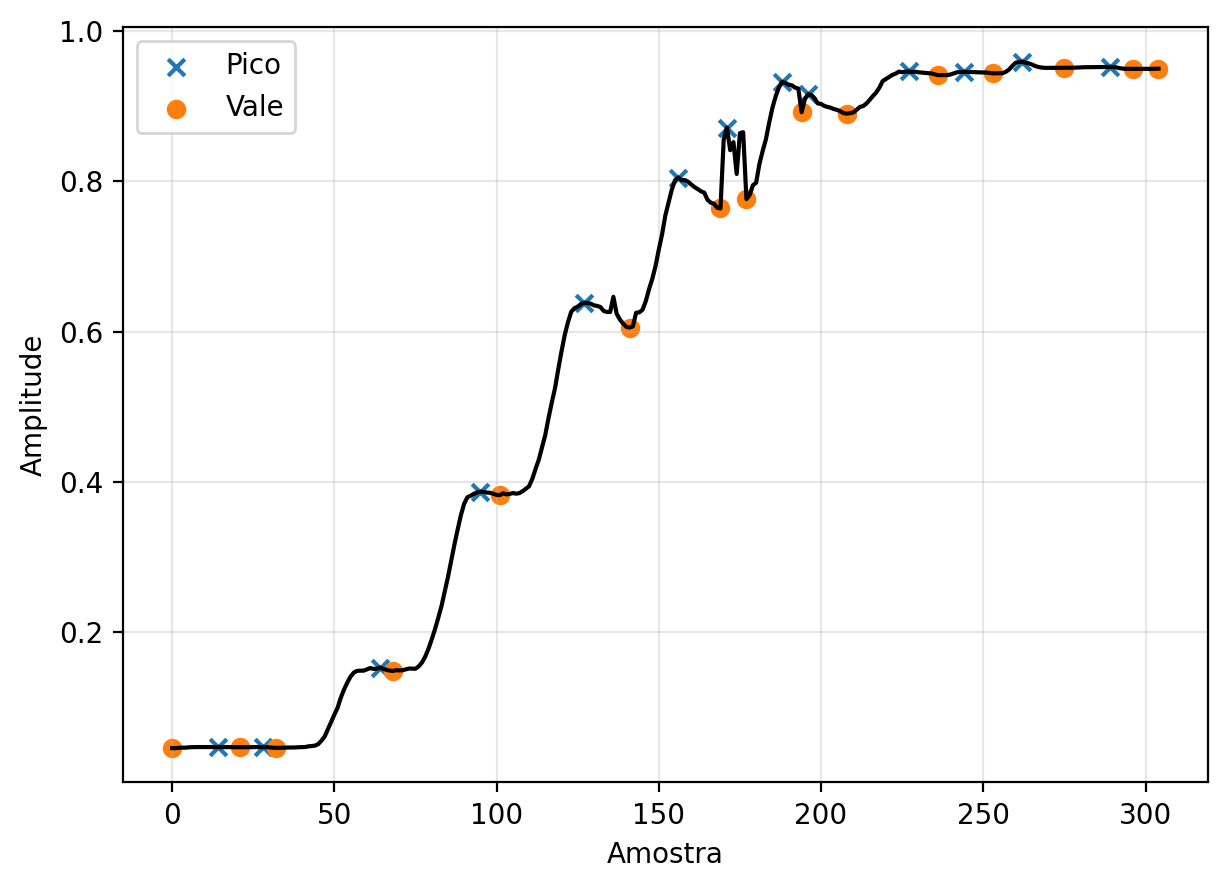

0.07537142528841893
[-1.18300319e-04  1.05667572e-01  2.33922288e-01  2.51250535e-01
  1.66667819e-01  6.63006306e-02  6.09103441e-02 -1.66268349e-02
  3.04801464e-02 -5.26428223e-04  1.34660602e-02 -6.93672895e-03]
[ 0.00120745 -0.00080105  0.10218901  0.23388481  0.22293919  0.1583333
  0.01249808  0.11561197 -0.00196815  0.05122447  0.00235546  0.0072524
 -0.00137275  0.00037712]
n° de passos:  13
velocidade:  0.09637657659830619
velocidade (passos):  1.278688524590164
foot off:  40.32786885245901


In [13]:
from findpeaks import findpeaks
fp = findpeaks(method='peakdetect', lookahead=5)

def plot_pv(results):
    #retorna os picos e vales apenas
    peak   = results['df'][results['df']['peak'] == True]
    valley = results['df'][results['df']['valley'] == True]

    #Mostra o gráfico
    plt.figure(dpi=200, figsize=(7,5))
    plt.grid(alpha=0.3)
    plt.plot(results['df']['x'], results['df']['y'], color='k')
    plt.scatter(peak['x'], peak['y'], label='Pico', marker='x')
    plt.scatter(valley['x'], valley['y'], label='Vale', marker='o')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return peak, valley

results1 = fp.fit(foot29_x)
peak, valley = plot_pv(results1)

dist_peaks  = np.diff(peak['y'])
dist_valley = np.diff(valley['y'])

step_lenght = abs(np.average(dist_peaks))

print(step_lenght)
print(dist_peaks)
print(dist_valley)

n_passos = len(peak)
velocidade_m = (n_passos * step_lenght)/tx[-1]
velocidade_p = (n_passos)/tx[-1]
print("n° de passos: ", n_passos)
print("velocidade: ", velocidade_m)
print("velocidade (passos): ", velocidade_p)
picos = peak.y
amostra = peak.x
#step_lenght = (picos[-1] - picos[0])/len(picos)

def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

foot29r = np.round(foot29_x-0.0005, 3)
nfoot_on = 0

for pico in picos:
    nfoot_on += countX(foot29r, round(pico-0.0005, 3))
    #foot_on += foot29_x
    nfoot_on += countX(foot29r, round(pico-0.0004, 3))
    #print(round(pico-0.0005, 3))
    
#print(nfoot_on)
#print(foot_on)
foot_off = ((len(foot29_x) - nfoot_on)/len(foot29_x)) *100
#print(len(foot29_x))
print("foot off: ", foot_off)

Obtenção do Centroide do Paralelogramo (Média entre as coordenadas dos vértices opostos)
(31x+30x/2,31y+30y/2)

In [14]:
centroidex = (foot31_x + foot30_x)/2
centroidey = (foot31_y + foot30_y)/2
centroide = (foot31_x + foot30_x)/2, (foot31_y + foot30_y)/2
print(centroidex)
print(centroidey)
transposta = list(map(lambda *i: [j for j in i], *centroide))
print(transposta)

#centroidex = transposta[:, 0]
#centroidey = transposta[:, 1]

[0.05521914 0.05604484 0.05626618 0.05657055 0.05623222 0.05669755
 0.057206   0.05718261 0.05719765 0.05723708 0.05716698 0.05694419
 0.05696604 0.05709445 0.0572705  0.05726579 0.05721695 0.05714899
 0.05689643 0.05673406 0.05665187 0.05660892 0.05659516 0.05663548
 0.05668187 0.05671844 0.05692691 0.05701721 0.05708835 0.05718393
 0.05714637 0.05708149 0.05696109 0.05698182 0.05700548 0.05710027
 0.05714768 0.05721044 0.05719938 0.057236   0.05716625 0.05719497
 0.05735124 0.05749606 0.05810859 0.05966737 0.0633854  0.06700945
 0.07094064 0.07450218 0.08007576 0.08453949 0.09012841 0.09607165
 0.10126291 0.10560235 0.10837536 0.11050067 0.11157843 0.1134088
 0.11514343 0.11709662 0.12182582 0.12831696 0.13541038 0.14085529
 0.14763203 0.15435935 0.16531008 0.17710593 0.18764415 0.19891804
 0.20864773 0.21859795 0.22392733 0.22525459 0.22567306 0.22609787
 0.22637027 0.22896961 0.23478647 0.24133521 0.24904361 0.25665919
 0.26976143 0.28116328 0.29441464 0.3080738  0.3169557  0.32666

Distância do CoG ao Centroide

[0.08927658 0.08798743 0.08570238 0.08465833 0.08404143 0.08489284
 0.08595413 0.08668318 0.08663345 0.08651891 0.08630551 0.0860198
 0.08604019 0.08620025 0.08637042 0.08639048 0.08627221 0.08589316
 0.08570934 0.08559831 0.08577152 0.08586578 0.08584996 0.08596547
 0.08597305 0.08596193 0.08615136 0.08615431 0.08615737 0.08618345
 0.08591089 0.08568915 0.08534355 0.08505277 0.08460342 0.08413353
 0.0832082  0.08210931 0.08128419 0.08025956 0.0797056  0.07847292
 0.07689363 0.07632443 0.07758689 0.07843005 0.07692926 0.07848776
 0.08079644 0.0819245  0.08518567 0.08621798 0.08844699 0.08946863
 0.08987558 0.08858253 0.08512038 0.08161491 0.07703279 0.07330184
 0.07281875 0.0748935  0.07520915 0.07452732 0.07324598 0.0752458
 0.07684816 0.07721957 0.07928935 0.0786033  0.08529927 0.09381852
 0.09793251 0.10150778 0.09936815 0.0925984  0.08734423 0.08452235
 0.09220647 0.09733826 0.09876648 0.10051901 0.09566779 0.09256591
 0.08639323 0.07962333 0.08621914 0.09303062 0.0951022  0.096406

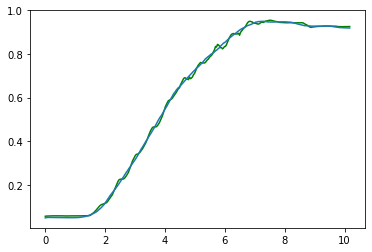

In [15]:
#Distância entre dois pontos
distancia_cog = np.sqrt((body_com_X-centroidex)**2) + ((body_com_Y-centroidey)**2)
print(distancia_cog)
print("distância média: ", np.average(distancia_cog))
plt.plot(tx, centroidex, 'g')
plt.plot(tx, body_com_X)

Distância do CoG a borda da BoS

In [16]:
#Distância do ponto às 4 retas (usar o menor valor como distância)
from itertools import chain

norm = np.linalg.norm

# Creating points
p1 = np.array([foot31]) #ponta esquerda
p2 = np.array([foot29]) #calcanhar esquerdo
p3 = np.array([foot32]) #ponta direita
p4 = np.array([foot30]) #calcanhar direito
p5 = np.array([body_com]) #cog
'''
p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
p5 = np.delete(body_com, 1, 1) #cog
'''
# Finding distance of p3 from a 
# line connecting p1 and p2

dis12 = np.abs((np.cross(p2-p1, p1-p5))/norm(p2-p1))
dis13 = np.abs((np.cross(p3-p1, p1-p5))/norm(p3-p1))
dis24 = np.abs((np.cross(p2-p4, p4-p5))/norm(p2-p4))
dis34 = np.abs((np.cross(p3-p4, p4-p5))/norm(p3-p4))

#print(dis12)

#print(pp)

dis12x = dis12[:, :, 0]
dis13x = dis13[:, :, 0]
dis24x = dis24[:, :, 0]
dis34x = dis34[:, :, 0]

dis12y = dis12[:, :, 1]
dis13y = dis13[:, :, 1]
dis24y = dis24[:, :, 1]
dis34y = dis34[:, :, 1]

menor1x = np.minimum(dis12x, dis13x)
menor2x = np.minimum(dis24x, dis34x)
distanciax = np.minimum(menor1x, menor2x)
#print(distanciax)

menor1y = np.minimum(dis12y, dis13y)
menor2y = np.minimum(dis24y, dis34y)
distanciay = np.minimum(menor1y, menor2y)
#print(distanciay)

distancia_borda = np.minimum(distanciax, distanciay)
print(distancia_borda)
distanciab_avg = np.average(distancia_borda)
distanciab_var = np.var(distancia_borda)
distanciab_desvio = np.std(distancia_borda)
print(distanciab_avg, distanciab_var, distanciab_desvio)

'''
menor1 = np.minimum(dis12, dis13)
menor2 = np.minimum(dis24, dis34)
distanciab = np.minimum(menor1, menor2)

distanciab_avg = np.average(distanciab)
distanciab_var = np.var(distanciab)
distanciab_desvio = np.std(distanciab)
print(distanciab_avg, distanciab_var, distanciab_desvio)
'''

[[1.79071513e-04 1.45955464e-04 4.31703814e-04 4.46267115e-04
  4.12746621e-04 3.71008056e-04 3.07107840e-04 2.00345863e-04
  2.15915696e-04 2.62613084e-04 2.64587061e-04 2.91869753e-04
  2.83099943e-04 2.83180045e-04 2.58634179e-04 2.46946182e-04
  2.47403975e-04 2.49409871e-04 2.55575683e-04 2.45631048e-04
  2.23344550e-04 1.99251057e-04 2.01661839e-04 2.05711823e-04
  2.21486015e-04 2.17511293e-04 2.12740353e-04 2.31864409e-04
  2.51019957e-04 2.70489980e-04 2.89423829e-04 3.00425694e-04
  3.06127444e-04 3.39095424e-04 3.16841987e-04 3.49717309e-04
  3.97346462e-04 4.70804682e-04 5.93358838e-04 5.56806625e-04
  5.89237352e-04 5.51504562e-04 5.99406996e-04 6.74690446e-04
  7.39990835e-04 6.64764130e-04 7.61462845e-04 1.03010055e-03
  5.49791628e-04 5.66404839e-04 1.72205883e-04 9.64215097e-05
  1.81938658e-04 6.49128963e-05 3.08288502e-04 4.47774117e-04
  2.04771728e-04 5.83369105e-04 1.23603670e-03 1.59977535e-03
  1.84689181e-03 1.23947542e-03 1.30387548e-03 9.15390147e-04
  5.8620

'\nmenor1 = np.minimum(dis12, dis13)\nmenor2 = np.minimum(dis24, dis34)\ndistanciab = np.minimum(menor1, menor2)\n\ndistanciab_avg = np.average(distanciab)\ndistanciab_var = np.var(distanciab)\ndistanciab_desvio = np.std(distanciab)\nprint(distanciab_avg, distanciab_var, distanciab_desvio)\n'

In [17]:
import math
#foot29 foot30 foot31 foot32
lado_direito = foot31_y - foot29_y
lado_esquerdo = foot32_y - foot30_y
diagonal_b = np.sqrt((foot29_x-foot30_x)**2) + ((foot29_y-foot30_y)**2)
diagonal_c = np.sqrt((foot31_x-foot32_x)**2) + ((foot31_y-foot32_y)**2)
print(diagonal_b)
print(diagonal_c)
centroide = [(diagonal_b+diagonal_c)/2, (lado_direito)]
h = foot29_x - foot30_x

[0.01375659 0.01129698 0.01125791 0.01112127 0.0109502  0.01044532
 0.01044906 0.01057542 0.01059571 0.0104791  0.0105287  0.01061248
 0.01069973 0.01058261 0.01023672 0.0101224  0.01019959 0.01022898
 0.0102102  0.01013498 0.01013709 0.01014301 0.01016467 0.01015456
 0.0100629  0.01003453 0.01010916 0.01013553 0.01017297 0.01019469
 0.00987191 0.00963319 0.00956512 0.0094173  0.00947351 0.00957625
 0.00971284 0.00960483 0.00972937 0.01006862 0.01023994 0.01039911
 0.01105732 0.01144447 0.01233515 0.01433413 0.01915677 0.0254517
 0.03651401 0.0464125  0.05683439 0.06581694 0.07931545 0.08975697
 0.09889475 0.10633051 0.1102282  0.1115861  0.11052766 0.10740289
 0.10631258 0.10578194 0.09577291 0.08429301 0.07397195 0.05989885
 0.04377478 0.02694911 0.00267163 0.01816408 0.04013574 0.06181872
 0.07766448 0.09496262 0.10672085 0.10978056 0.107201   0.10387137
 0.09741951 0.08985242 0.07980864 0.06492728 0.04852316 0.03090832
 0.01145832 0.01089405 0.03036931 0.05318496 0.07312573 0.09243

In [18]:
def calculate_area(c):

    '''
    Calculates the area of any quadrivaletral
    from a list of x,y coordinates in the following format:

    [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    '''

    first = c[0][0]*c[1][1] + c[1][0]*c[2][1] + c[2][0]*c[3][1] + c[3][0]*c[0][1]

    second = c[1][0]*c[0][1] + c[2][0]*c[1][1] + c[3][0]*c[2][1] + c[0][0]*c[3][1]

    area = 0.5*(first - second)

    return area

p1 = np.delete(foot31, 1, 1) #ponta esquerda
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
c = np.concatenate((p1,p2,p3,p4), axis = 1)
area = calculate_area(c)
print(p1)

[[ 7.77499527e-02  5.09997681e-02]
 [ 7.70540759e-02  4.06541899e-02]
 [ 7.71497488e-02  8.37364867e-02]
 [ 7.71492422e-02  8.97951350e-02]
 [ 7.64541551e-02  8.83592591e-02]
 [ 7.64757320e-02  6.34462461e-02]
 [ 7.72567242e-02  6.26845807e-02]
 [ 7.72614405e-02  4.34484072e-02]
 [ 7.72626698e-02  4.73293625e-02]
 [ 7.72058293e-02  6.01612218e-02]
 [ 7.71444887e-02  6.19706921e-02]
 [ 7.68273845e-02  6.95708022e-02]
 [ 7.68826231e-02  6.78351074e-02]
 [ 7.69475996e-02  7.01846108e-02]
 [ 7.69445822e-02  6.92595318e-02]
 [ 7.68382028e-02  6.88941032e-02]
 [ 7.68307000e-02  7.20444247e-02]
 [ 7.67519549e-02  7.33219236e-02]
 [ 7.64033869e-02  7.39925653e-02]
 [ 7.60942847e-02  7.32097700e-02]
 [ 7.59429559e-02  7.13820830e-02]
 [ 7.58611187e-02  6.83508590e-02]
 [ 7.58440867e-02  6.76340386e-02]
 [ 7.58327916e-02  6.84001371e-02]
 [ 7.58342519e-02  6.92417771e-02]
 [ 7.58725405e-02  6.87978789e-02]
 [ 7.62909278e-02  6.78936690e-02]
 [ 7.64778852e-02  7.11336955e-02]
 [ 7.66410306e-02  7

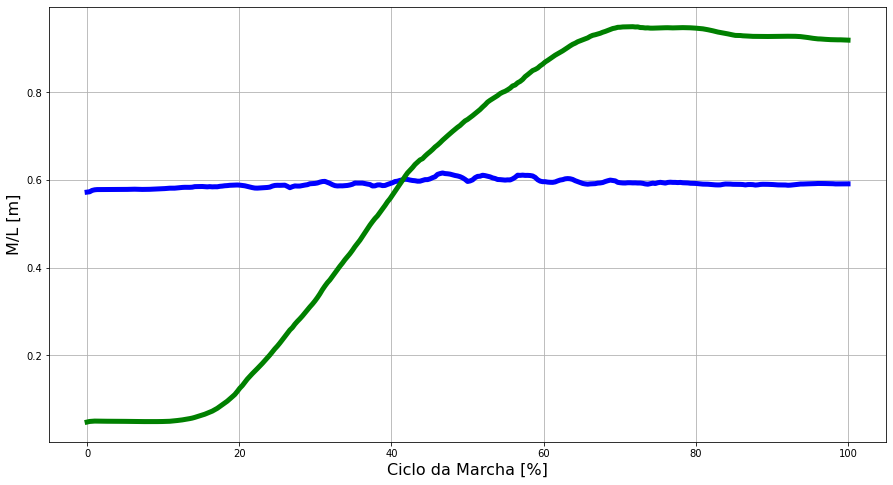

In [19]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_Y, color = 'b', linewidth = 5)
plt.plot(GaitCycle, body_com_X, color = 'g', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(ty, foot29_y, 'go')
#plt.plot(ty, foot30_y, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

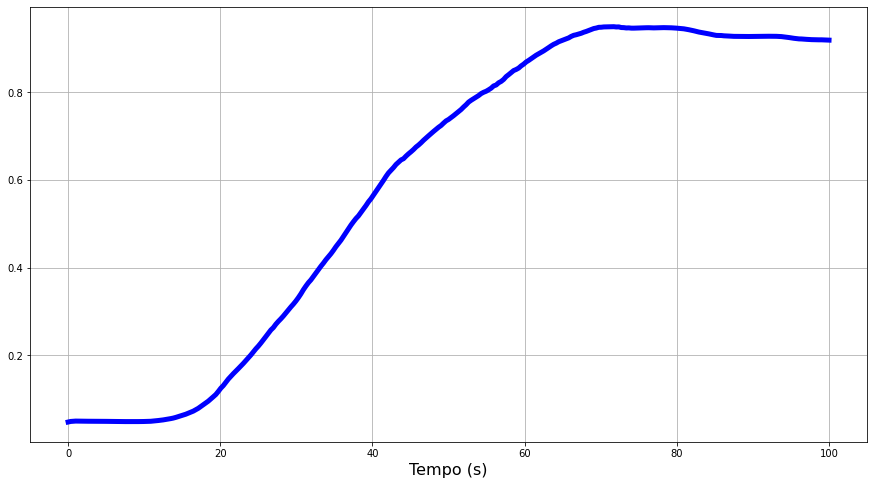

In [20]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_X, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

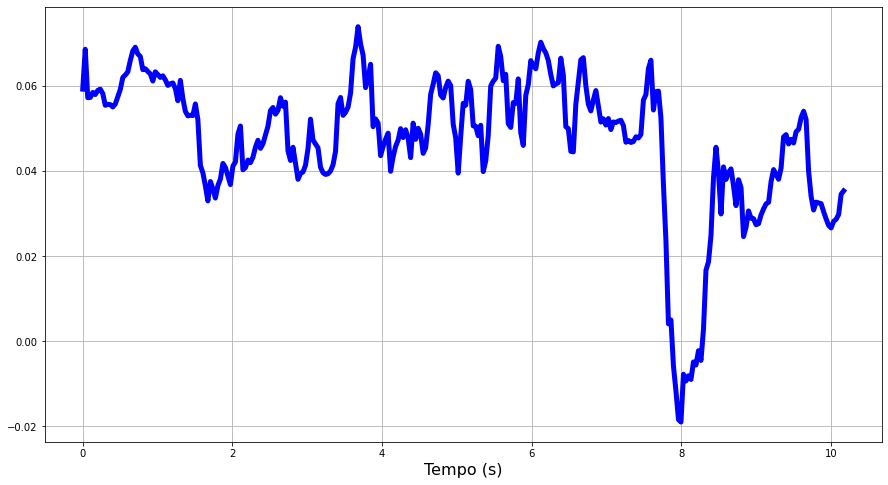

In [21]:

plt.figure(figsize=[15,8])
plt.plot(tz, body_com_Z, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


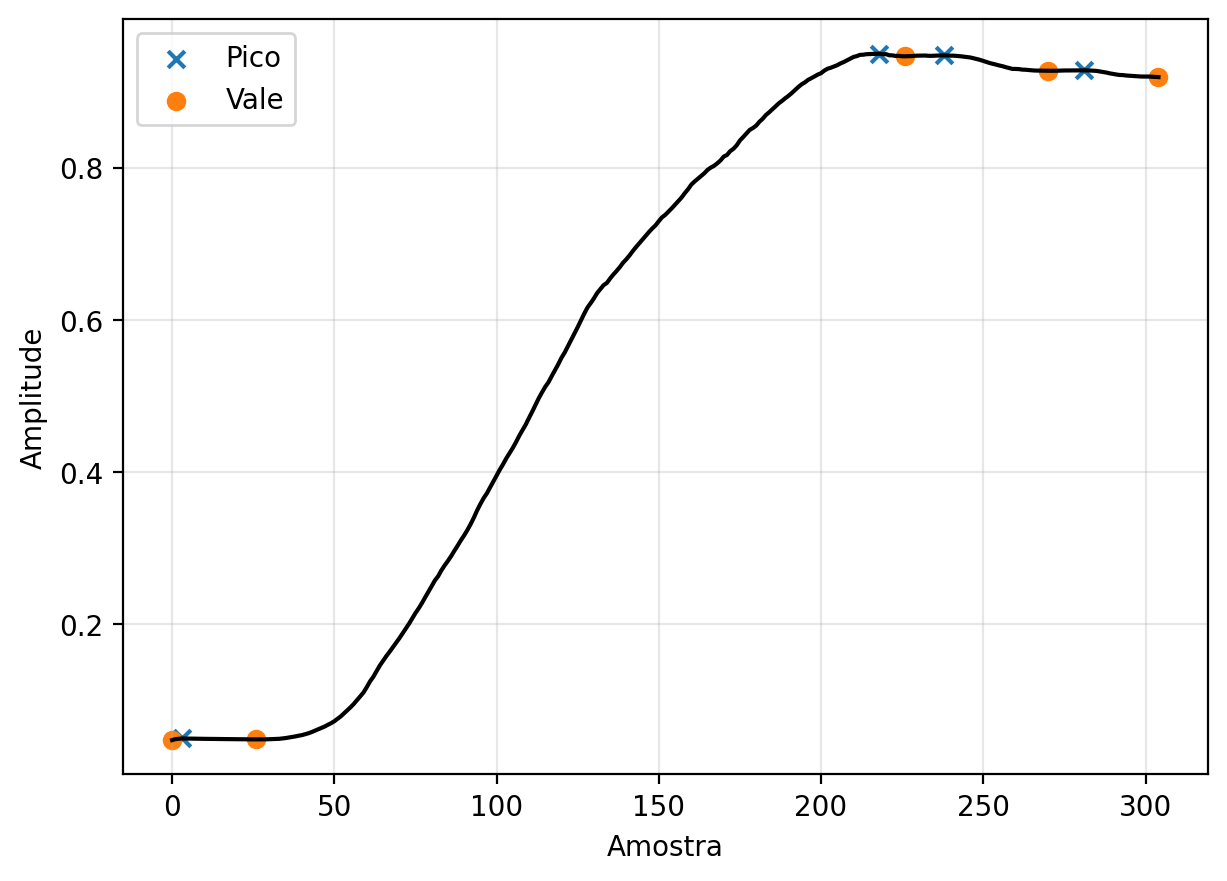

[215  20  43]
[ 26 200  44  34]


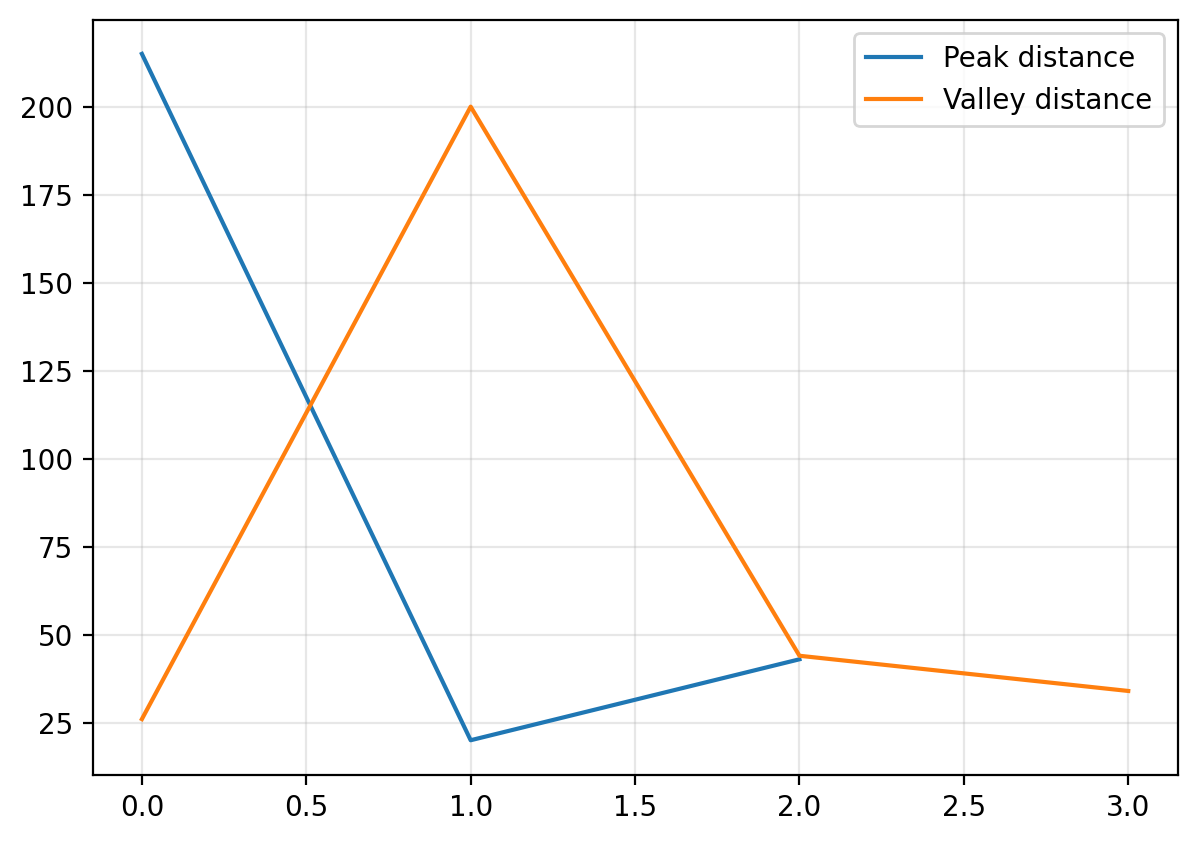

5


In [22]:


#Chama a função com os resultados obtidos anteriormente
#matriz = np.concatenate((tx, filteredx))
results = fp.fit(body_com_X)
peak, valley = plot_pv(results)

dist_peaks  = np.diff(peak['x'])
dist_valley = np.diff(valley['x'])

print(dist_peaks)
print(dist_valley)

plt.figure(dpi=200, figsize=(7,5))
plt.grid(alpha=0.3)
plt.plot(dist_peaks, label='Peak distance')
plt.plot(dist_valley, label='Valley distance')
plt.legend()
plt.show()

print(len(valley))

In [23]:
#print(2*filteredx[45]-filteredx[0])

# Filtragem

In [24]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# apply a 2-pole lowpass filter at 0.15x Nyquist frequency (15 hz is half the max frequency of the video (30Hz))
bx, ax = scipy.signal.butter(2, 0.2)
filteredx = scipy.signal.filtfilt(bx, ax, body_com_X, axis=0)

by, ay = scipy.signal.butter(2, 0.2)
filteredy = scipy.signal.filtfilt(by, ay, body_com_Y, axis=0)

bz, az = scipy.signal.butter(2, 0.2)
filteredz = scipy.signal.filtfilt(bz, az, body_com_Z, axis=0)

b30z, a30z = scipy.signal.butter(2, 0.2)
filtered30z = scipy.signal.filtfilt(b30z, a30z, foot30_z, axis=0)

b29z, a29z = scipy.signal.butter(2, 0.2)
filtered29z = scipy.signal.filtfilt(b29z, a29z, foot29_z, axis=0)

b30y, a30y = scipy.signal.butter(2, 0.2)
filtered30y = scipy.signal.filtfilt(b30y, a30y, foot30_y, axis=0)

b29y, a29y = scipy.signal.butter(2, 0.2)
filtered29y = scipy.signal.filtfilt(b29y, a29y, foot29_y, axis=0)

b30x, a30x = scipy.signal.butter(2, 0.2)
filtered30x = scipy.signal.filtfilt(b30x, a30x, foot30_x, axis=0)

b29x, a29x = scipy.signal.butter(2, 0.2)
filtered29x = scipy.signal.filtfilt(b29x, a29x, foot29_x, axis=0)


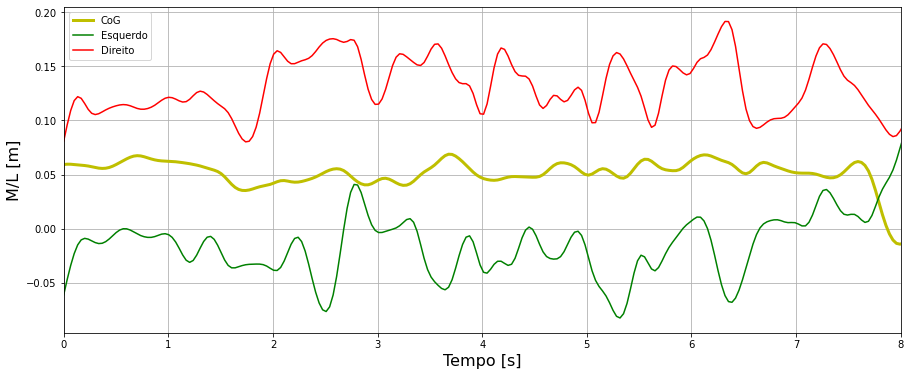

In [40]:
plt.figure(figsize=[15, 6])
plt.plot(tx, filteredz, color = 'y', linewidth = 3)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.plot(tx, filtered30z, 'g')
plt.plot(tx, filtered29z, 'r')
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.xlim(0, 8)
plt.legend(['CoG', 'Esquerdo', 'Direito'])
#plt.ylim(0.03, 0.07)
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


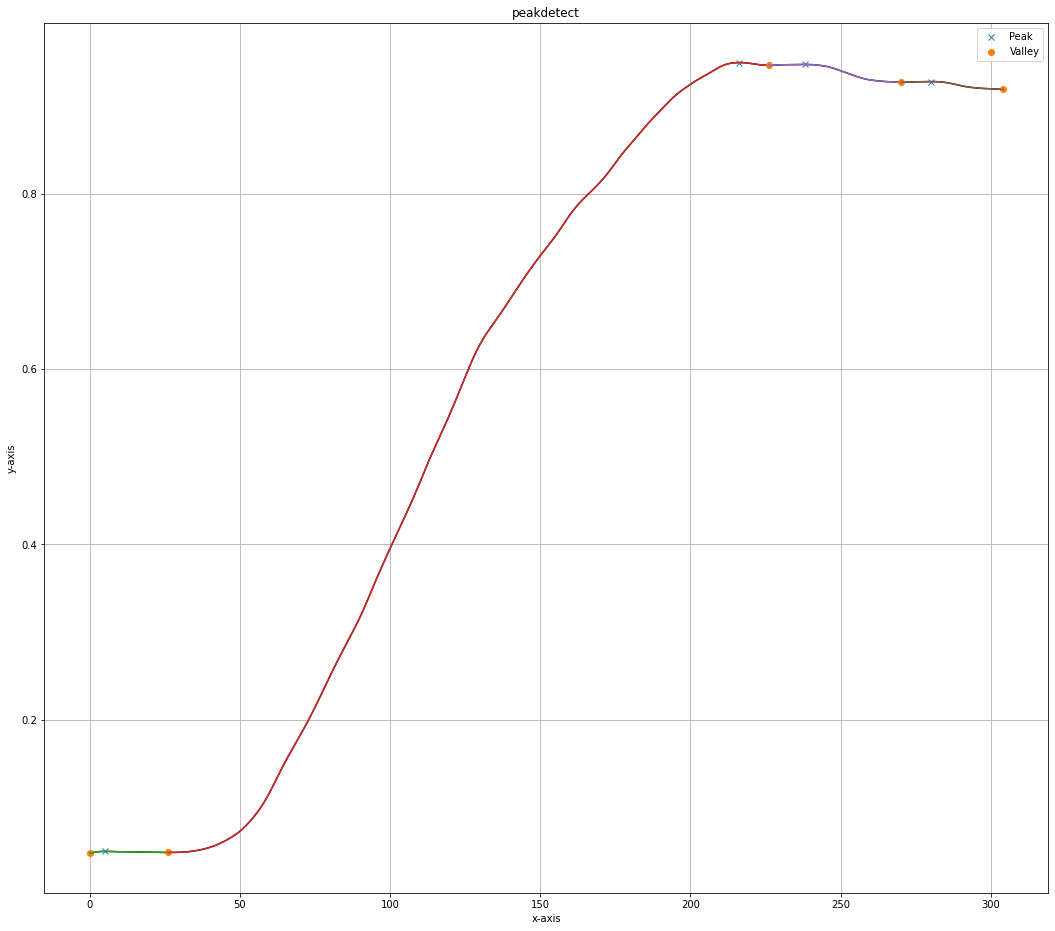

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [27]:

results = fp.fit(filteredx)
fp.plot(figsize=(18,16))


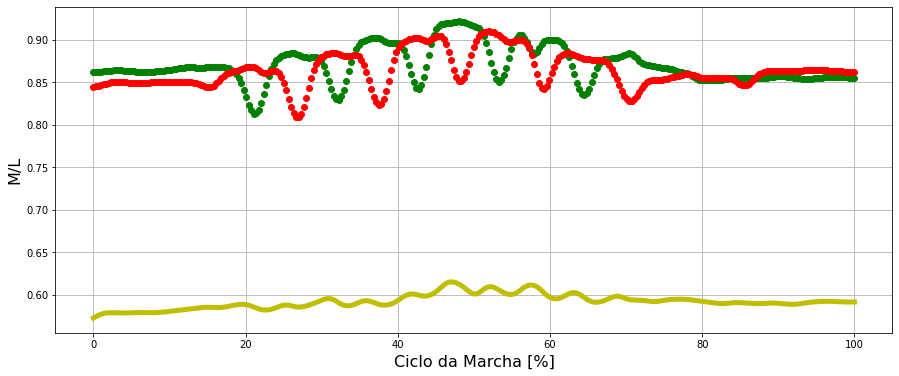

In [28]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredy, color = 'y', linewidth = 5)
plt.ylabel('M/L', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30y, 'go')
plt.plot(GaitCycle, filtered29y, 'ro')
#plt.ylim(0.6, 0.9)
#plt.title('', fontsize=16)
plt.grid()
plt.show()

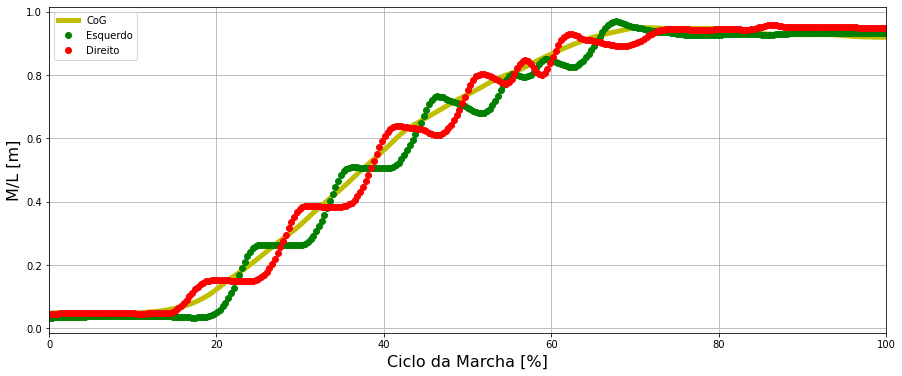

In [29]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30x, 'go')
plt.plot(GaitCycle, filtered29x, 'ro')
plt.xlim(0, 100)
plt.legend(['CoG', 'Esquerdo', 'Direito'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

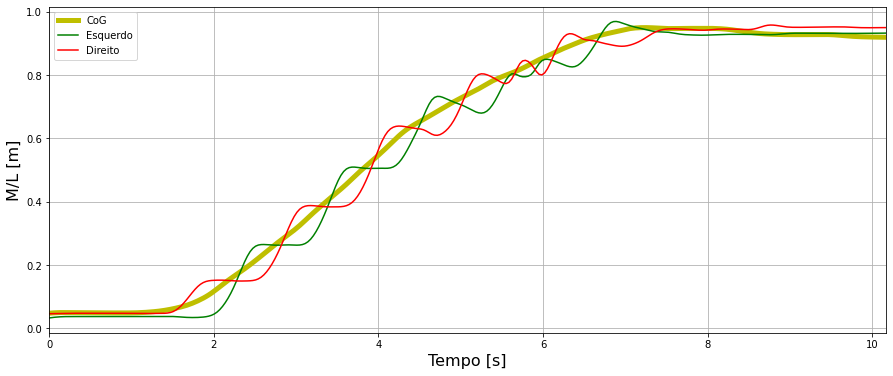

In [30]:
plt.figure(figsize=[15, 6])
plt.plot(tx, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.plot(tx, filtered30x, 'g') # esquerdo
plt.plot(tx, filtered29x, 'r') # direito
plt.xlim(0, tx[-1])
plt.legend(['CoG', 'Esquerdo', 'Direito'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

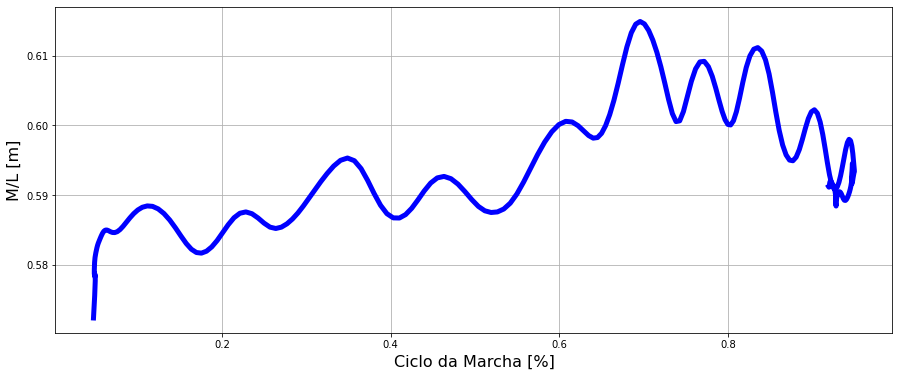

In [35]:
plt.figure(figsize=[15, 6])
#plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.plot(filteredx, filteredy, color = 'b', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.plot(GaitCycle, filtered30x, 'go')
#plt.plot(GaitCycle, filtered29x, 'ro')
#plt.xlim(0, 100)
#plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

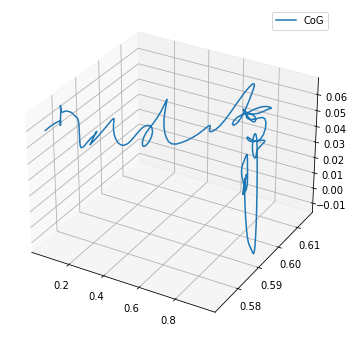

In [32]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=[15, 6]).add_subplot(projection='3d')

ax.plot(filteredx, filteredy, filteredz, label='CoG')
ax.legend()
plt.show()